# Title

## Setting up the data

First we need to import all the relevant libraries as well as set up the data.

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
id = "1TWLh-ITBli8jHVnxHikSxYK5Y5xLVtvo"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("AUS_Functions.py")

In [83]:
id = "13uHFskGhnt9oaXiBmG1l7GPysFjNBMn-"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("LCDataDictionary.xlsx")

In [5]:
id = "1j1OsCeSErTVMnK-_acQ81tot2WQ8xfSI"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("original_columns.csv")
df2 = pd.read_csv("original_columns.csv", index_col = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (37,96) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from AUS_Functions import *
from shapely.geometry import Polygon, MultiPolygon
import re

In [6]:
sns.set()
colors = {
    "blue": "#4C72B0",
    "orange": "#DD8452",
    "green": "#55A868",
    "red": "#C44E52",
    "grey": "#8C8C8C",
    "black": "#000000",
    "blue_transparent": "#4C72B080"
}


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin

## EDA

Since the three tasks we want to accomplish use different datasets and features in those datasets, I've split the EDA into several parts to cover only the relevant datasets and columns to the task at hand.

Data relevant to our task is split into two datasets - one containing rejected and the other containing accepted loan applications. So before we can properly do EDA, we must combine the datasets together. 

Let's take a look at the rejected data first.

In [ ]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


The dataset is quite large - there are more than 27 million entries. Taking up 2 GB of RAM, it's more than my computer can easily process. Let's see how best should we go about sampling the dataset.

In [ ]:
df.isnull().sum()

Amount Requested               0
Application Date               0
Loan Title                  1303
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

We can see that there are quite a lot of missing values, especially for the "risk_score" feature. A good first step at getting a smaller dataset could be dropping the rows with missing values. However, we need to be careful with doing that - since about 2/3 of the whole dataset has missing values, by dropping them we could heavily alter the natural distributions for the features, especially, if the values are not missing completely at random.

To check, we will compare samples from untouched data and from data with dropped missing values.

In [ ]:
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df_sample = df.sample(frac = 0.1)
df = df.dropna(axis=0)
df = df.sample(frac = 0.25)

df["dropna"] = 1
df_sample["dropna"] = 0
df = pd.concat([df, df_sample])
df = df.reset_index(drop=True)
del(df_sample)

df.head()

amount_requested application_date               loan_title  risk_score  \
0            2500.0       2018-06-16                    Other       572.0   
1           15000.0       2017-10-16       Debt consolidation       624.0   
2            5000.0       2017-11-20  Credit card refinancing       653.0   
3           10000.0       2016-11-17                 Business       557.0   
4           30000.0       2017-07-03  Credit card refinancing       606.0   

  debt_to_income_ratio zip_code state employment_length  policy_code  dropna  
0                   0%    183xx    PA           3 years          0.0       1  
1               69.61%    748xx    OK          < 1 year          0.0       1  
2                35.8%    076xx    NJ          < 1 year          0.0       1  
3               22.62%    945xx    CA          < 1 year          0.0       1  
4              127.04%    350xx    AL          < 1 year          0.0       1

Differences in distributions for most features were miniscule, except for the "application_date".

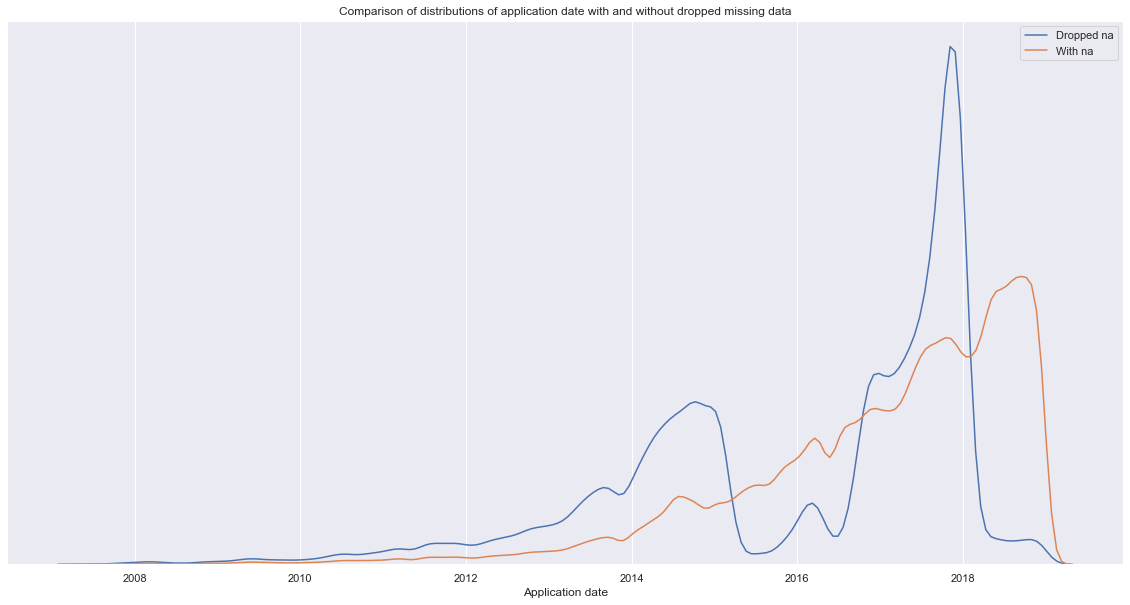

In [ ]:
df["application_date"] = pd.to_datetime(df["application_date"])
df["month"] = df["application_date"].dt.month

plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="dropna",
    palette=[colors["orange"], colors["blue"]],
    common_norm=False
)
plt.legend(labels=["Dropped na", "With na"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_title("Comparison of distributions of application date with and without dropped missing data")
ax.set_yticks([])

plt.show()

There seems to be a lot of missing data in 2015, 2016 and 2019.

Let's check the difference for the data split by month - one of the most likely ways we might use the application_date feature.

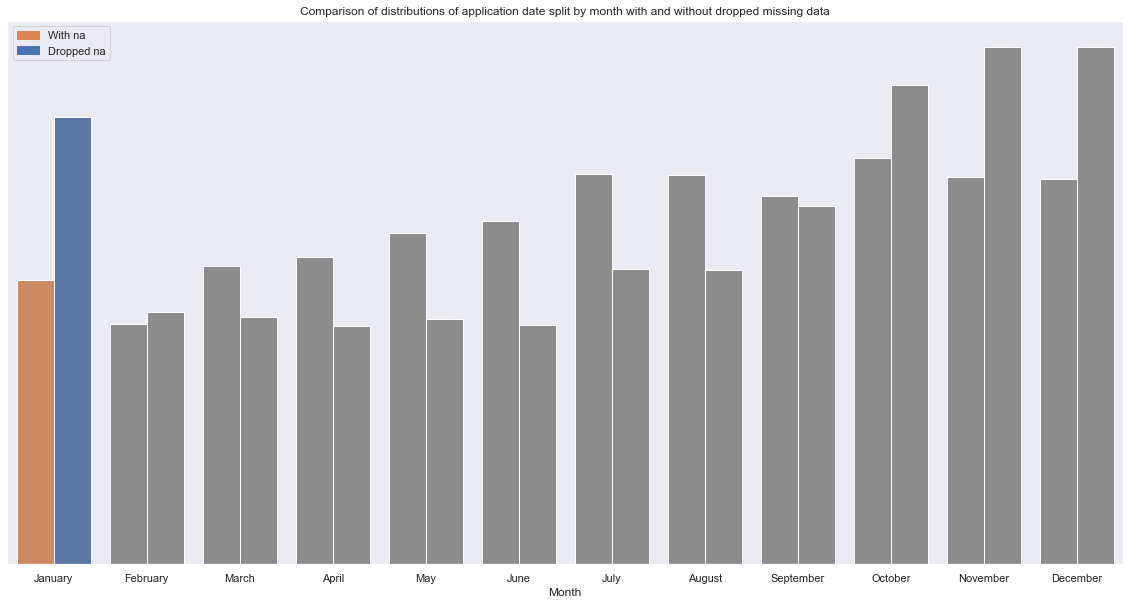

In [ ]:
df_month = df.loc[:, ["month", "dropna", "policy_code"]]
df_month.index.name = "id"
months_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
df_month["month"] = df_month["month"].replace(months_dict)
df_month["month"] = pd.Categorical(df_month["month"], categories=list(list(months_dict.values())))

draw_comparison_barplot(df_month, "dropna", "month", ["January"], ["Comparison of distributions of application date split by month with and without dropped missing data", "Month", "", "With na", "Dropped na"], mode="proportion", y_labels=False)

We can see that there is quite a pronounced difference in some months - the most extreme being in January.

Before we proceed let's quickly compare the date and month data between accepted and rejected datasets - to see how important the feature might be for discerning between the two.

In [ ]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()
df = df.sample(frac = 0.1)

df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

df["accepted"] = 0
df2["accepted"] = 1
df = df.loc[:, ["application_date", "accepted"]]
df2 = df2.loc[:, ["issue_d", "accepted"]]
df2 = df2.rename(columns={"issue_d":"application_date"})

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

df["application_date"] = pd.to_datetime(df["application_date"])
df = df.dropna(axis=0)
df["month"] = df["application_date"].dt.month
df["month"] = df["month"].replace(months_dict)
df["month"] = pd.Categorical(df["month"], categories=list(list(months_dict.values())))

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11664\1051733384.py:5: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


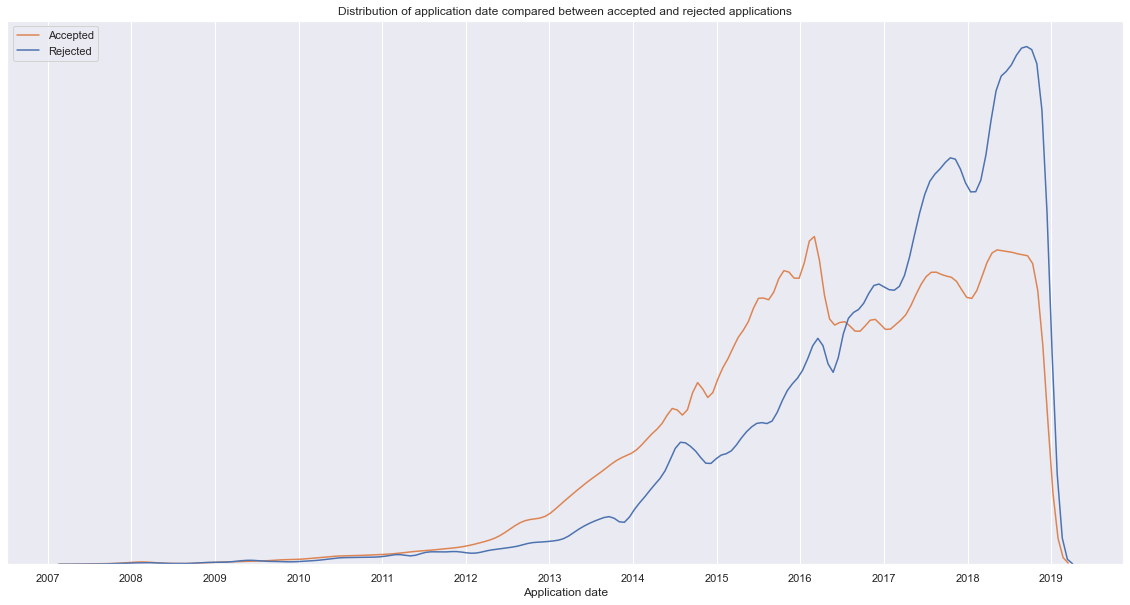

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="accepted",
    palette=[colors["blue"], colors["orange"]],
    common_norm=False
)
plt.legend(labels=["Accepted", "Rejected"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_xticks(pd.to_datetime([str(2007 + x) for x in range(13)]))
ax.set_xticklabels([2007 + x for x in range(13)])
ax.set_title("Distribution of application date compared between accepted and rejected applications")
ax.set_yticks([])

plt.show()

We can see that something must have happened to the market in 2016 (perhaps the (stock market crash due to Brexit?)[https://en.wikipedia.org/wiki/2015%E2%80%932016_stock_market_selloff#:~:text=The%20vote%20led%20to%20stock,dollars%20by%20June%2027%2C%202016.] ) that made applications a lot less likely to be accepted - while the number of rejected applications has continued to grow, the amount of accepted applications hadn't recovered yet in the 2019. Excluding that the distributions seem quite alike.

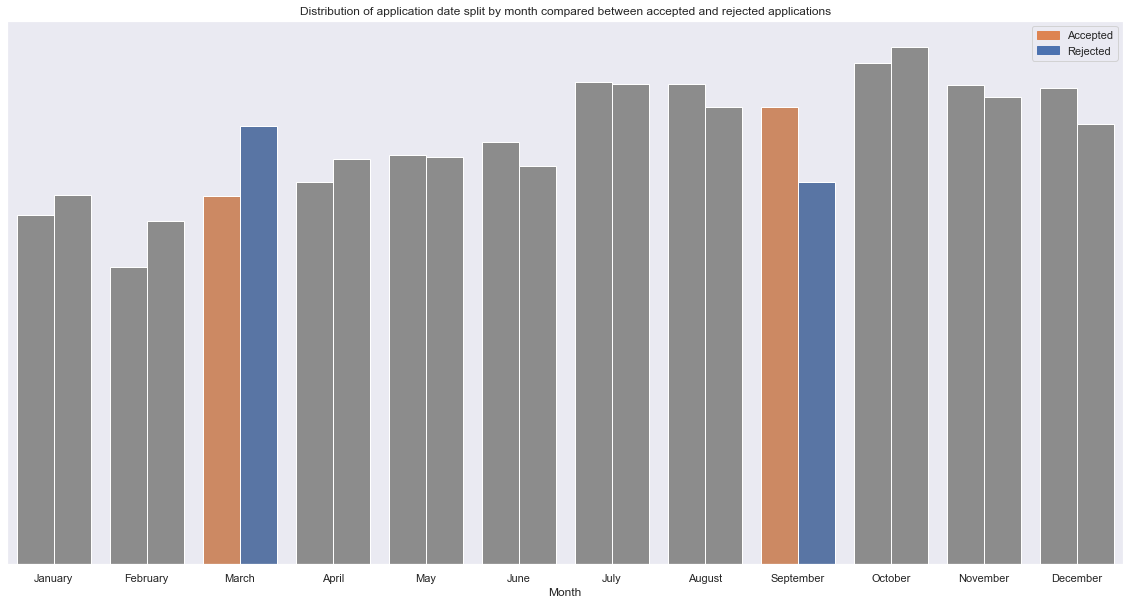

In [ ]:
df.index.name = "id"
draw_comparison_barplot(df, "accepted", "month", ["March", "September"], ["Distribution of application date split by month compared between accepted and rejected applications", "Month", "", "Accepted", "Rejected"], mode="proportion", y_labels=False)

If we look at the difference of distributions between months, there seem to be several that contain different proportion compared to the other distribution. However, if we look at the previous graph, we can attribute the unequal proportions in March to the 2016 crash event. For September a single event is harder to spot, however, there also doesn't seem to be an obvious yearly pattern for it. 

Overall, it seems like date and month data is not that important for the task and we can drop the column and all the rows with missing values. I think that the data we get will be better - since we won't have any missing data to impute and all the entries will contain actual data.

In [ ]:
def df2_to_df(df2):
    df2 = df2.loc[:, ["loan_amnt", "title", "fico_range_low", "fico_range_high", "dti", "zip_code", "addr_state", "emp_length", "loan_status"]]
    df2["risk_score"] = (df2["fico_range_low"] + df2["fico_range_high"])/2
    df2["accepted"] = 1
    df2.loc[df2["loan_status"] == "Charged Off","accepted"] = 2
    df2 = df2.drop(["fico_range_low", "fico_range_high", "loan_status"], axis=1)
    
    df2_name_dict = {
        "loan_amnt":"amount_requested",
        "title":"loan_title",
        "dti":"debt_to_income_ratio",
        "addr_state":"state",
        "emp_length":"employment_length"
    }
    df2 = df2.rename(columns=df2_name_dict)
    return df2

In [ ]:
def clean_data(df):
    df["employment_length"] = df["employment_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["employment_length"] = df["employment_length"].str.extract(r"([0-9]+)").astype("float")
    df = df.rename(columns={"employment_length" : "employment_length_years"})
    df["debt_to_income_ratio"] = df["debt_to_income_ratio"].replace("%", "", regex=True).astype(float)
    df["amount_requested"] = df["amount_requested"].astype(int)
    
    df.loc[:, "loan_title"] = df["loan_title"].str.lower().replace("[^a-zA-Z0-9]", " ", regex=True)

    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df

In [ ]:
def zip_state_to_coordinates(df):
    df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
    df["bin"] = df["zip_code"].str.strip("x") + df["state"]
    df = df.merge(bin_coord_means.reset_index(), on="bin", how="left")
    df = df.merge(state_coord_means.reset_index(), on="state", how="left")
    df["latitude"] = df["latitude"].fillna(df["state_latitude"])
    df["longitude"] = df["longitude"].fillna(df["state_longitude"])
    df.drop(["zip_code", "bin", "state"], axis=1, inplace=True)
    
    return df

In [ ]:
def customize_us_shapefile(states):
    states = states.loc[states["STUSPS"].isin(df["state"].unique())]
    states.loc[states["NAME"]=="Alaska", "geometry"] = states.loc[states["NAME"]=="Alaska", "geometry"].scale(0.3, 0.3)
    states.loc[states["NAME"]=="Alaska", "geometry"] = states.loc[states["NAME"]=="Alaska", "geometry"].translate(-10000000, -3000000)
    states.loc[states["NAME"]=="Hawaii", "geometry"] = states.loc[states["NAME"]=="Hawaii", "geometry"].translate(3000000, 1500000)

    alaska = states.loc[states["NAME"]=="Alaska", "geometry"]
    alaska_geom = alaska[47]
    alaska_bool_list = []
    for P in alaska_geom.geoms:
        alaska_bool_list.append(P.bounds[0]< -10000000)
    alaska = alaska.explode(index_parts=True)
    alaska = alaska.reset_index().set_index("level_1")
    alaska = MultiPolygon(list(alaska[alaska_bool_list].geometry))

    states.loc[states["NAME"]=="Alaska", "geometry"] = pd.Series([alaska]).values
    
    return states

In [ ]:
def draw_usa(df, column, title, legend=True):
    
    ax = df.plot(figsize=(30, 10), column=column, legend=legend)
    ax.plot([-14200000, -14200000], [7000000, 5000000], linewidth=2, color=colors["black"])
    ax.plot([-14200000, -16500000], [5000000, 5000000], linewidth=2, color=colors["black"])
    ax.plot([-14200000, -13500000], [5000000, 3000000], linewidth=2, color=colors["black"])
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

In [ ]:
def get_relevant_words(df, target):
    word_df = pd.Series([y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]).value_counts().to_frame("total")
    word_df["total"] = (word_df["total"]/word_df["total"].sum()).round(3)
    for index, value in enumerate(["rejected", "accepted"]):
        word_df[value] = pd.Series([y for x in df.loc[target == index, "loan_title"].dropna().values.flatten() for y in x.split()]).value_counts()
        word_df[value] = (word_df[value]/word_df[value].sum()).round(3)

    difference_words = (word_df[np.abs(word_df["rejected"]-word_df["accepted"]) > 0.01]).index.to_list()

    word_df = pd.DataFrame(index=df.index)
    for word in difference_words:
        word_df.loc[df["loan_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), word] = 1
        word_df.loc[:, word] = word_df.loc[:, word].fillna(0).astype(int)

        word_corr = word_df.corrwith(word_df[word])
        multicoll_list = word_corr[(word_corr > 0.7) & (word_corr.index != word)].index.tolist()
        if multicoll_list:
            for multicoll_name in multicoll_list:
                if np.abs(word_df[multicoll_name].corr(target)) < np.abs(word_df[word].corr(target)):
                    word_df = word_df.drop(multicoll_name, axis=1)
                else:
                    word_df = word_df.drop(word, axis=1)
                    break
    return word_df.columns.to_list()

In [ ]:
df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')
df2 = df2_to_df(df2)
df2.shape[0]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_8088\522979848.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


2260701

Dataset containing accepted data has a lot of columns that are not relevant to us and the column names are different than for the rejected data, so we use a custom function that filters out the data that we need and renames the columns.

We can see that accepted dataset has only 2 million entries - a lot less than the rejected dataset even after we've excluded the missing data. To balance out the datasets and make the complete size manageable, we will be sampling the accepted dataset to approximately the same size as the rejected dataset.

In [ ]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')
df = df.dropna(axis=0)
df = df.sample(frac = 0.25)
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df["accepted"] = 0
df = df.drop(["policy_code", "application_date"], axis=1)

We also have to drop the "policy code" feature - the feature is related to the action taken ("accepted", "rejected") and thus contains information unknown to us at the moment of prediction.

In [ ]:
df2.isnull().sum()

amount_requested            33
loan_title               23358
debt_to_income_ratio      1744
zip_code                    34
state                       33
employment_length       146940
risk_score                  33
accepted                     0
dtype: int64

We dropped all the missing entries in the rejected dataset, but there are some in the accepted dataset that we will have to deal with.

In [ ]:
df2 = df2.drop(df2[df2["amount_requested"].isnull()].index, axis=0)

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

del(df2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   amount_requested      float64
 1   loan_title            object 
 2   risk_score            float64
 3   debt_to_income_ratio  object 
 4   zip_code              object 
 5   state                 object 
 6   employment_length     object 
 7   accepted              int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 275.2+ MB


After combining both the accepted data and the sample from rejected dataset, we get 4.5 million entries. Memory usage is still high due to most of the features having been designated as containing strings, but hopefully with some data cleaning and engineering we'll be able to bring it down.

In [ ]:
df.head()

amount_requested               loan_title  risk_score debt_to_income_ratio  \
0            1000.0  Credit card refinancing       570.0               42.82%   
1           40000.0           Major purchase       751.0                  20%   
2            5000.0       debt_consolidation       579.0               34.92%   
3            1500.0       debt_consolidation       695.0                3.66%   
4            7000.0              credit_card       648.0               20.77%   

  zip_code state employment_length  accepted  
0    902xx    CA          < 1 year         0  
1    773xx    TX          < 1 year         0  
2    754xx    TX          < 1 year         0  
3    954xx    CA          < 1 year         0  
4    891xx    NV          < 1 year         0

We can see that some of the string columns actually contain numeric data - debt_to_income_ratio column contains percentages, while employement_length contains discrete numeric data. We will use a custom function to transform the features to numeric as well as downcast all numeric columns as much as possible to minimize the memory usage of the data. Zip_code also contains numbers, but we will look at it later.

In [ ]:
df = clean_data(df)
df_copy = df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amount_requested         int32  
 1   loan_title               object 
 2   risk_score               float32
 3   debt_to_income_ratio     float32
 4   zip_code                 object 
 5   state                    object 
 6   employment_length_years  float32
 7   accepted                 int8   
dtypes: float32(3), int32(1), int8(1), object(3)
memory usage: 176.3+ MB


We can see that memory usage is smaller now.

In [ ]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

amount_requested     risk_score debt_to_income_ratio  \
count    4508717.00000  4508717.00000        4507006.00000   
mean       13843.39351      664.02002             89.50935   
std        10157.07826       77.02917           3986.81006   
min          300.00000        0.00000             -1.00000   
25%         5200.00000      636.00000             10.89000   
50%        10500.00000      675.00000             18.73000   
75%        20000.00000      702.00000             28.43000   
max      1400000.00000      990.00000        3225600.00000   

      employment_length_years       accepted  
count           4361810.00000  4508717.00000  
mean                  4.06340        0.56096  
std                   5.67515        0.60449  
min                   0.00000        0.00000  
25%                   0.00000        0.00000  
50%                   0.00000        1.00000  
75%                   6.00000        1.00000  
max                  15.00000        2.00000

Some of the features - "amount_requested" and "debt_to_income_ratio" seem to be quite heavily right skewed.

In [ ]:
accepted_to_words = {0:"Rejected", 1:"Accepted", 2:"Charged off"}
df["accepted"].value_counts().rename(index=accepted_to_words)

Rejected       2248049
Accepted       1992109
Charged off     268559
Name: accepted, dtype: int64

Our target column - accepted is currently split into 3 values - rejected applications, accepted applications and accepted applications that got charged off. "Charged off" means that the applicator has been negligent to his due payments for long enough that the creditor no longer believes that the debt will be payed and cuts his losses. It might improve our model if we exclude theses failed cases.

Now that we've combined the data and cleaned up the data a bit, let's take a closer look at each of the features.

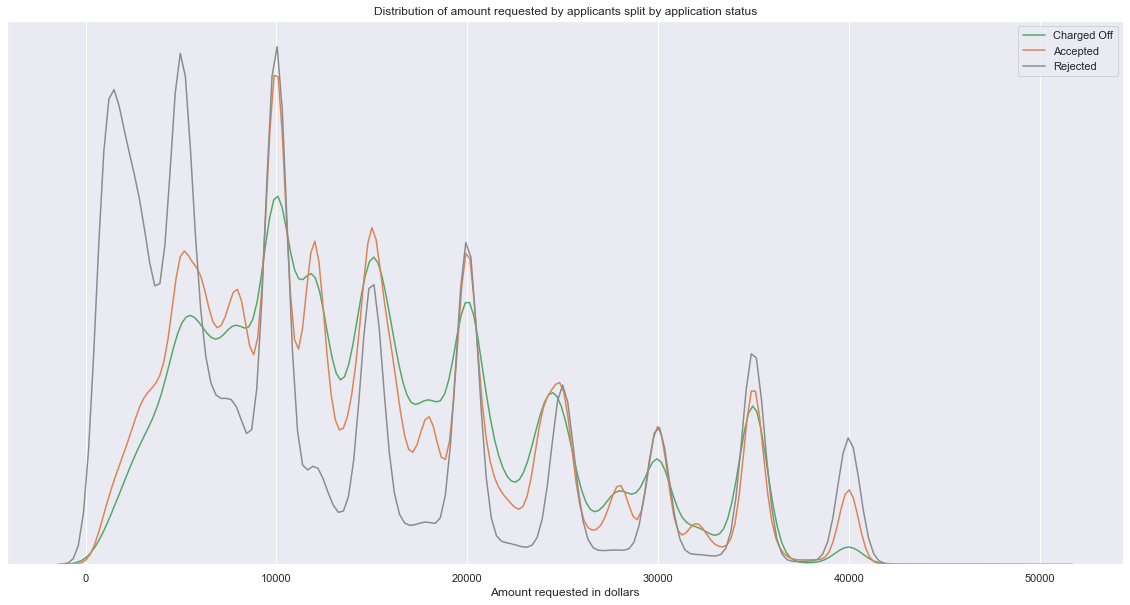

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["amount_requested"]<50000],
    x="amount_requested",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Amount requested in dollars", ylabel="")
ax.set_title("Distribution of amount requested by applicants split by application status")
ax.set_yticks([])

plt.show()

Since amount_requested feature was so heavily skewed, to better see the differences in distributions for the main body of entries, we have excluded the long tail. There is quite a large difference in distributions from 0 to around 7000 dollars with a lot more rejected applications - seems like investors tend to not be interested in lending such small amounts. There doesn't seem to be much of a difference between accepted and charged off applications.

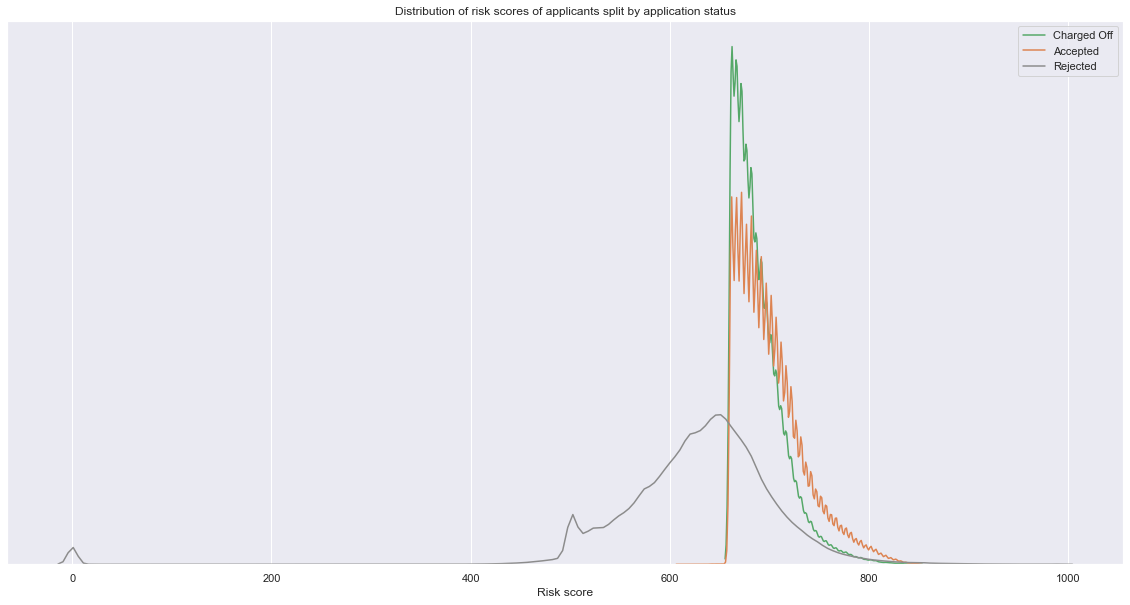

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="risk_score",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [ ]:
df.loc[df["accepted"]==1, "risk_score"].sort_values().quantile(0.0001)

647.0

For the risk_score feature we can see that the distributions are quite different. For accepted aplications there are basically no entries under risk score of 647, while the rejected values range from 400 up to over 800. Charged off entries tend to also have a smaller risk score than other accepted entries. Also there seem to be a number of entries with risk score 0 - since 0 is an invalid value for risk score, most likely given to an applicant that hasn't had his risk score measured, we'll have to treat them as missing values.

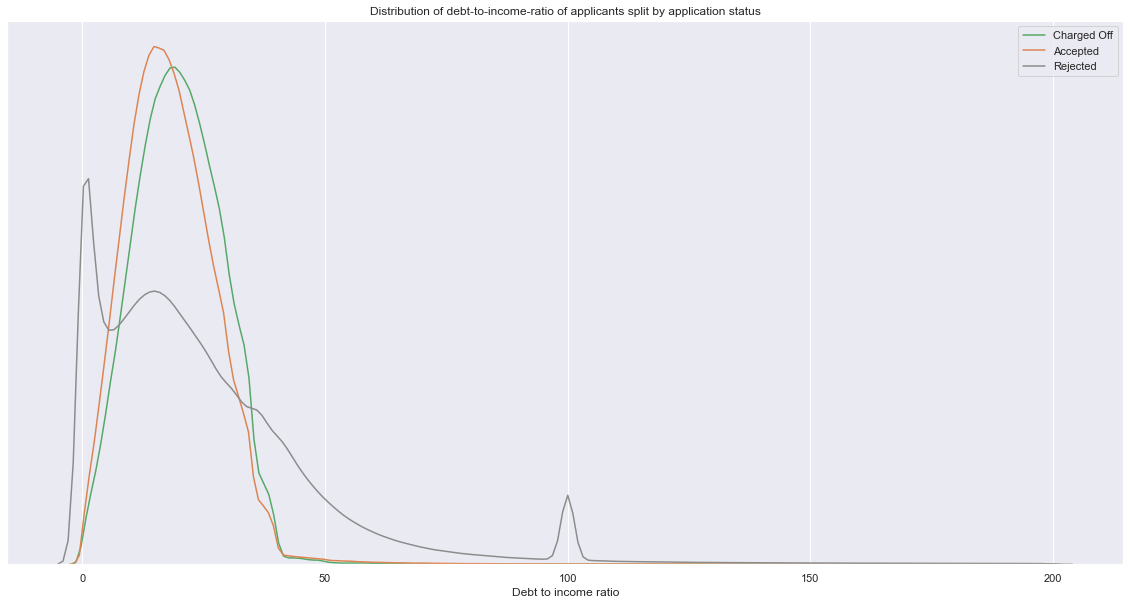

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["debt_to_income_ratio"]<200],
    x="debt_to_income_ratio",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Debt to income ratio", ylabel="")
ax.set_title("Distribution of debt-to-income-ratio of applicants split by application status")
ax.set_yticks([])

plt.show()

In [ ]:
df.loc[df["debt_to_income_ratio"]<0, "debt_to_income_ratio"].value_counts()

-1.0    3810
Name: debt_to_income_ratio, dtype: int64

Debt-to-income-ratio feature was heavily skewed, so, in order to see the difference in distributions, we will again be cutting off the long tail. We can again see quite large differences in distributions for this feature. Applicants that have debt-to-income-ratio of either 0 or above 45 seem a lot less likely to be accepted than the applicants whose debt-to-income-ratio is inbetween. Also, there seem to be some entries with a negative value, which is invalid for this feature - we will be considering those values as missing data.

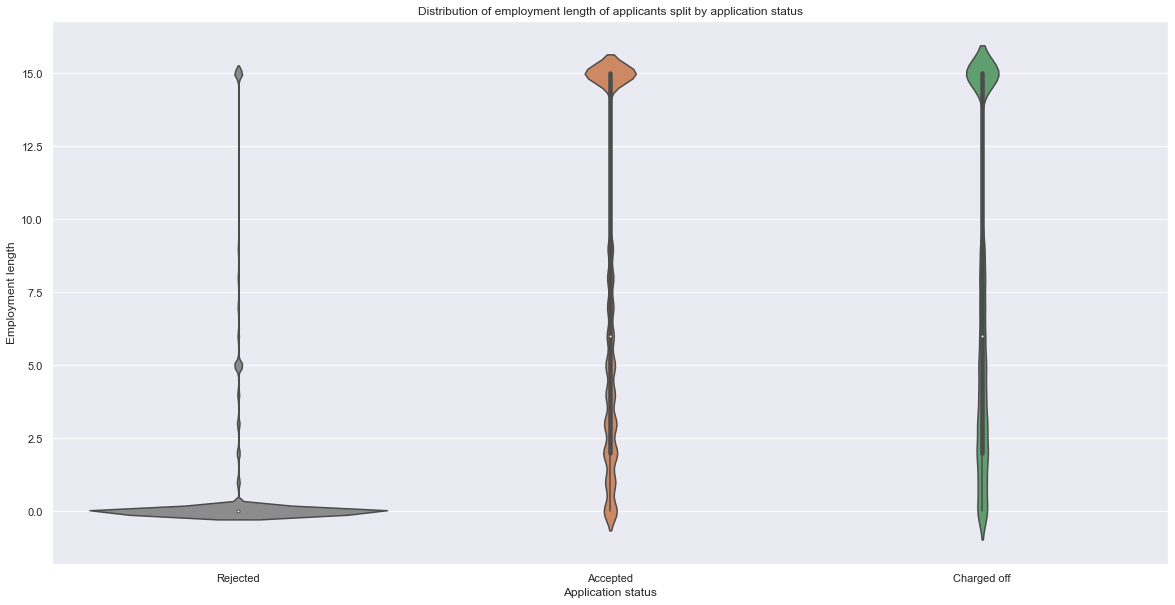

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.violinplot(
    y=df["employment_length_years"],
    x=df["accepted"].replace(accepted_to_words),
    palette=[colors["grey"], colors["orange"], colors["green"]]
)
ax.set(xlabel="Application status", ylabel="Employment length")
ax.set_title("Distribution of employment length of applicants split by application status")

plt.show()

We can see quite extreme differences in distributions for employement_length feature. Almost all of the rejected applicants had worked in their current job for less than a year, while the majority of accepted applicants had worked in their workplace for more than 10 years. 

Next let's take a look at some of the columns containing strings, starting with the loan_title column. We'll count all the different words for entries, split them by status and then check their proportions of total word count per split.

In [ ]:
word_df = pd.Series([y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]).value_counts().to_frame("total")
word_df["total"] = (word_df["total"]/word_df["total"].sum()).round(3)
for index, value in enumerate(["rejected", "accepted", "charged_off"]):
    word_df[value] = pd.Series([y for x in df.loc[df["accepted"] == index, "loan_title"].dropna().values.flatten() for y in x.split()]).value_counts()
    word_df[value] = (word_df[value]/word_df[value].sum()).round(3)

difference_words = (word_df[np.abs(word_df["rejected"]-word_df["accepted"]) > 0.01]).index.to_list()

In [ ]:
word_df.head(10)

total  rejected  accepted  charged_off
debt           0.248     0.248     0.244        0.270
consolidation  0.248     0.248     0.244        0.270
credit         0.086     0.068     0.105        0.085
card           0.085     0.067     0.103        0.082
refinancing    0.071     0.040     0.099        0.078
other          0.052     0.082     0.026        0.026
home           0.032     0.031     0.033        0.029
improvement    0.027     0.024     0.030        0.026
car            0.015     0.028     0.005        0.004
purchase       0.012     0.015     0.010        0.009

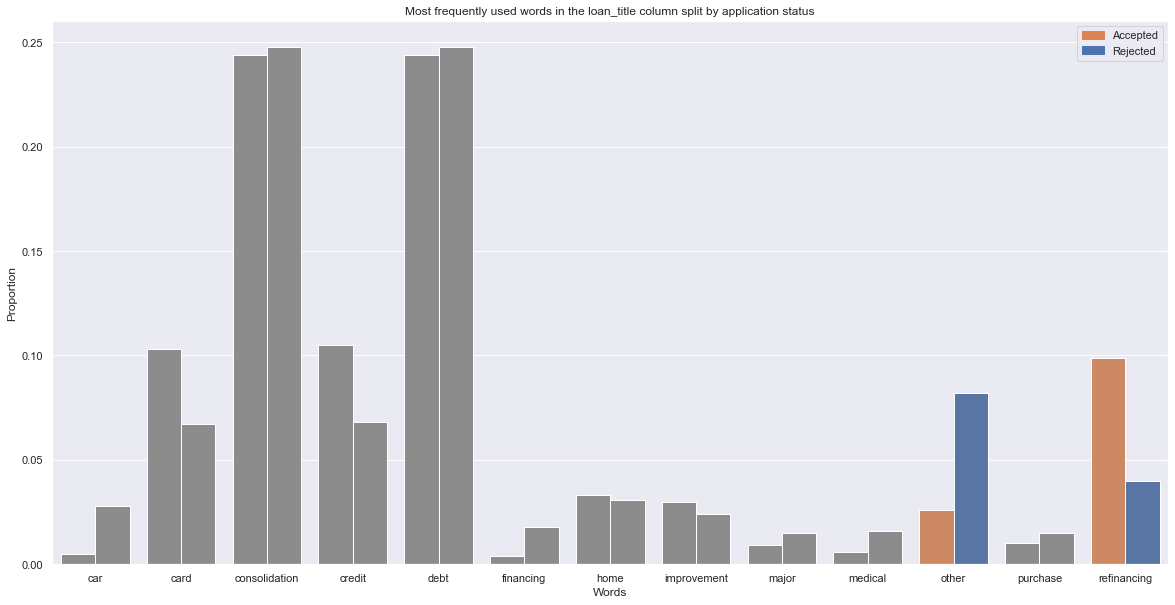

In [ ]:
word_df = word_df.loc[word_df["total"] > 0.01, ["rejected", "accepted"]]
word_df = word_df.unstack().reset_index().rename(columns={"level_0":"accepted", "level_1":"word", 0:"count"})
word_df.index.name = "id"

draw_comparison_barplot(word_df, "accepted", "word", ["other", "refinancing"], ["Most frequently used words in the loan_title column split by application status", "Words", "Proportion", "Accepted", "Rejected"], mode="")

We can see that some words are being used in the title a lot more frequently than others - words "debt" and "consolidation" together make up almost half of the total words used. For some words, like "other" and "refinancing", the difference in proportions is quite large and we might use them as features for our model. 

Next we'll look at the state and zip_code columns. 

In [ ]:
states = geopandas.read_file("data/maps/tl_2012_us_state.shp")
us_pop_df = pd.read_csv('data/2019_Census_US_Population_Data_By_State_Lat_Long.csv')

states = customize_us_shapefile(states)

loans_states_count = df.groupby("state")["accepted"].count().rename("count")
states = states.merge(loans_states_count, left_on = "STUSPS", right_index=True)
states = states.merge(us_pop_df.set_index("STATE")["POPESTIMATE2019"], left_on = "NAME", right_index=True, how="left")
states["applications_per_thousand"] = states["count"]/(states["POPESTIMATE2019"]/1000)

KeyError: 'state'

Let's start by just plotting the absolute loan application count per state.

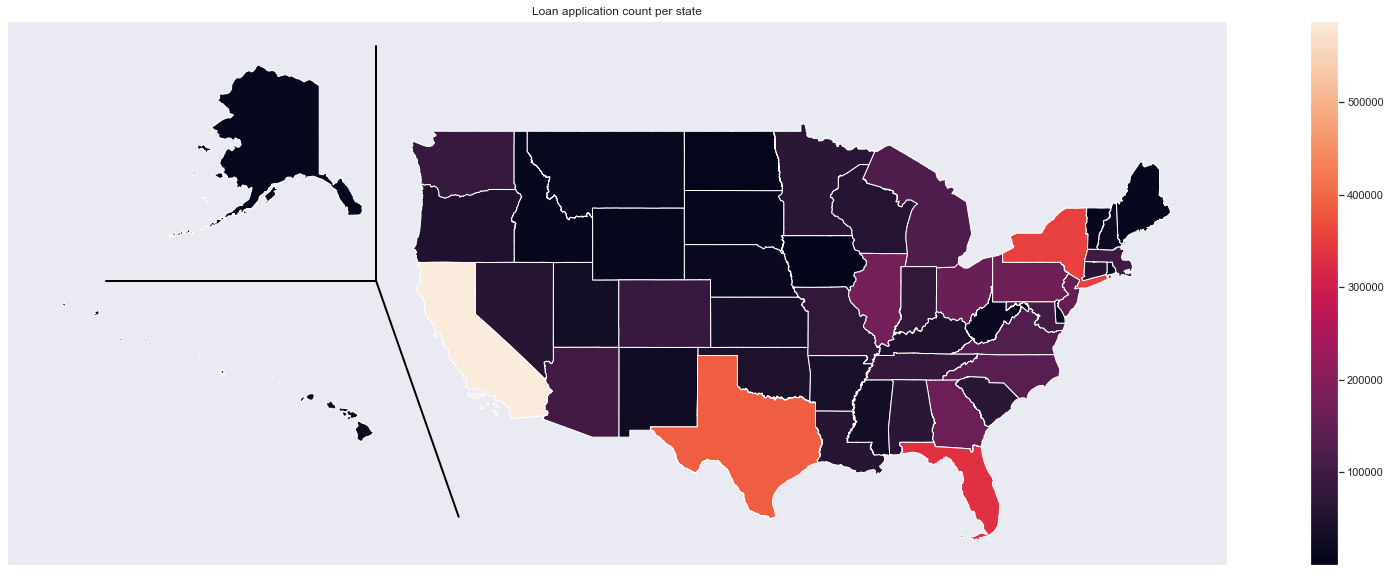

In [ ]:
draw_usa(states, "count", "Loan application count per state")

We can see that a few states - most notably California and Texas have a huge amount of loan applications. However, the absolute numbers of applications might be misleading in this case due to the differring population counts between the states.

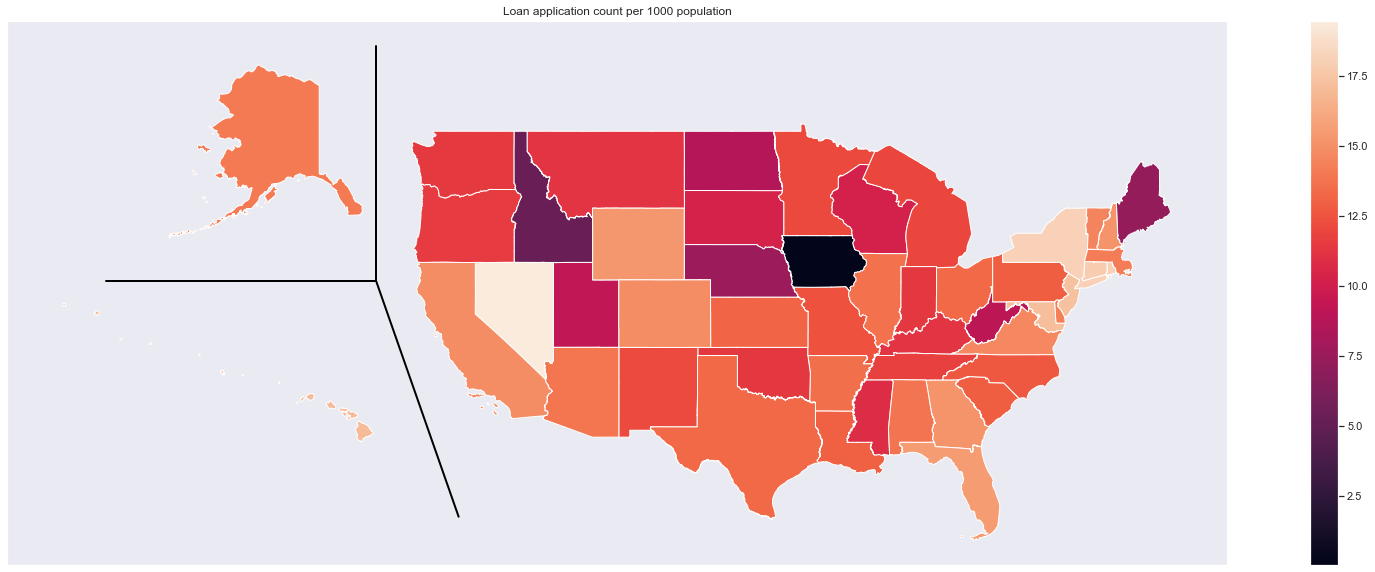

In [ ]:
draw_usa(states, "applications_per_thousand", "Loan application count per 1000 population")

If we look at a map containing normalized data - application count per 1000 population in each state - the high population states are not as prevalent as in the previous plot. There seem to be more per person applications in the New York area, but otherwise people seem to be more likely to apply for a loan in the southern part of the country compared to the more northern states. Two outlier states are Iowa with extremely low amount of applications and Nevada with the opposite - in Iowa's case it could be explained by a low population and thus a sample too small to be stable, while Nevada's high number could be explained by relatively low population combined with being adjacent to California.

Next let's look at the ratios between application statuses in each of the states.

In [ ]:
ratios_states = df.groupby("state")["accepted"].value_counts().rename("count").to_frame().unstack()
ratios_states.columns = ratios_states.columns.get_level_values(1)
ratios_states["accepted_charged_off_ratio"] = ratios_states[2]/ratios_states[1]
ratios_states["accepted_rejected_ratio"] = ratios_states[0]/(ratios_states[1]+ratios_states[2])
ratios_states = ratios_states.drop([0, 1, 2], axis=1)

states = states.merge(ratios_states, left_on = "STUSPS", right_index=True, how="left")

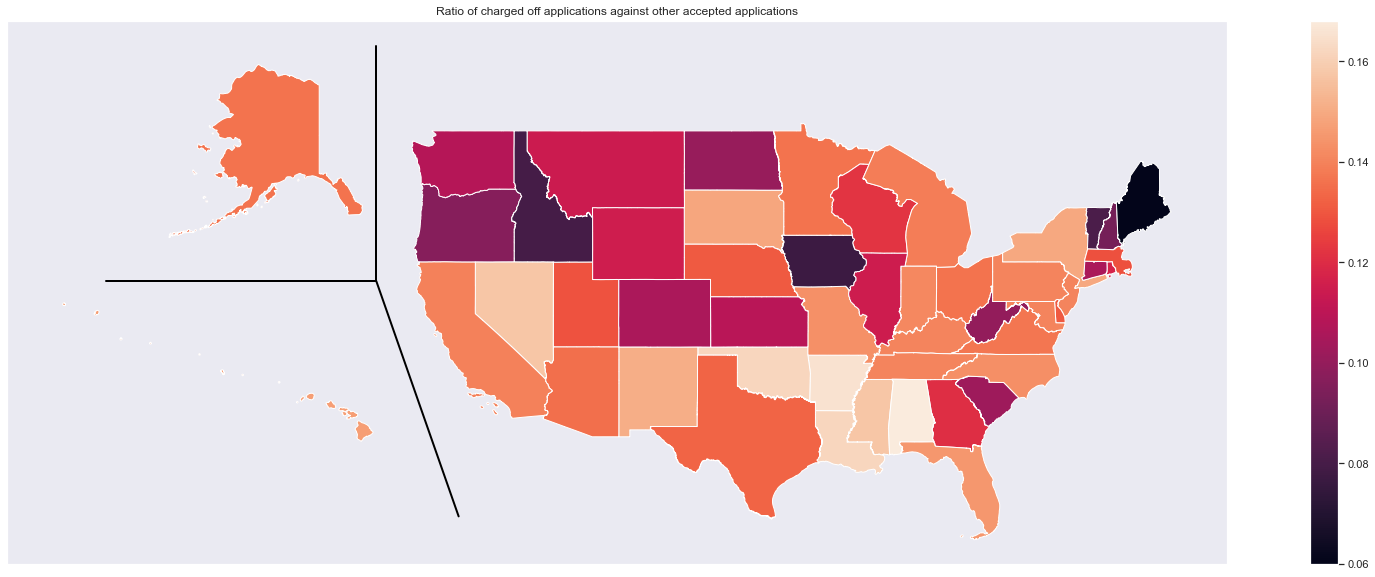

In [ ]:
draw_usa(states, "accepted_charged_off_ratio", "Ratio of charged off applications against other accepted applications")

In [ ]:
states.loc[states["accepted_charged_off_ratio"].sort_values(ascending=False)[:5].index].loc[:, ["NAME", "count", "accepted_charged_off_ratio"]]

NAME  count  accepted_charged_off_ratio
31    Alabama  67508                    0.143899
1    Arkansas  41034                    0.141736
17  Louisiana  60311                    0.139485
14   Oklahoma  45303                    0.139336
54     Nevada  59678                    0.136050

Looking at the ratio between charged off and accepted applications, we again see the difference between southern and northern states with the southern part of the country having a higher charged off ratio. Especially high the ratio seems to be in the states around Alabama.

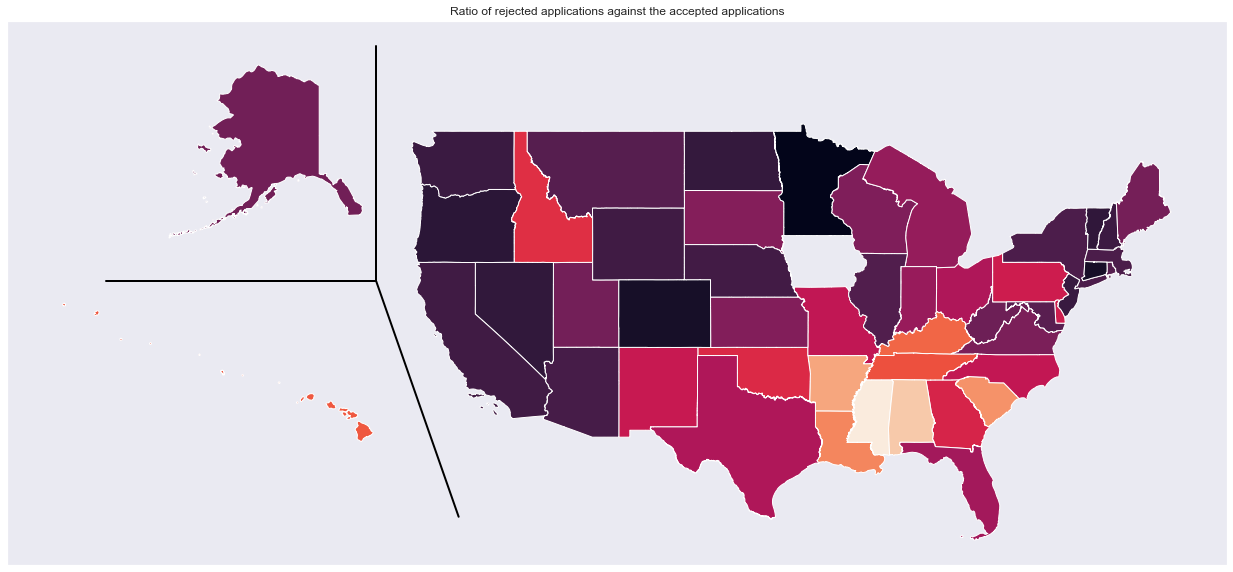

In [ ]:
draw_usa(states[states["NAME"]!="Iowa"], "accepted_rejected_ratio", "Ratio of rejected applications against the accepted applications", legend=False)

And here again we see that the ratio of rejected applications is especially high in the Alabama region. Note that since we are using a sample for rejected data and the complete dataset for accepted data, the ratios calculated here, while being accurate in comparison between the states are by themselves misleading, so I've excluded the legend here. Also note that we have excluded Iowa from this graph due to having an extremely low value.

And finally let's look at the zip_code.

In [ ]:
zip_df = pd.read_csv("data/US_zip_codes_coordinates.txt", sep="\t", header=None)
zip_df = zip_df.drop([0, 2, 3, 5, 6, 7, 8, 11], axis=1)
zip_df.columns = ["zip_code", "state", "latitude", "longitude"]
zip_df = zip_df.dropna(axis=0)

zip_df["bin"] = np.floor(zip_df["zip_code"] / 100).astype(int).astype(str).str.zfill(3) + zip_df["state"]
state_coord_means = zip_df.groupby("state")[["latitude", "longitude"]].mean()
state_coord_means = state_coord_means.rename(columns={"latitude":"state_latitude", "longitude":"state_longitude"})
bin_coord_means = zip_df.groupby("bin")[["latitude", "longitude"]].mean()

zip_df.head()

zip_code state  latitude  longitude    bin
0     99553    AK   54.1430  -165.7854  995AK
1     99571    AK   55.1858  -162.7211  995AK
2     99583    AK   54.8542  -163.4113  995AK
3     99612    AK   55.0628  -162.3056  996AK
4     99661    AK   55.3192  -160.4914  996AK

Even though zip code contains numbers, they don't represent ordinal data. One way we can convert both zip codes and state names to numerical data is to look up their physical location as latitude and longitude. Since we are missing last two digits for the values in zip_code feature, we'll have to take the average geographical values between all the possible zip codes for each entry.

In [ ]:
df = zip_state_to_coordinates(df)

df.head()

amount_requested          loan_title  risk_score  debt_to_income_ratio  \
0             20000  debt consolidation       632.0             48.540001   
1             20000  debt consolidation       673.0             76.250000   
2              1000  debt consolidation       631.0              0.000000   
3              1000              moving       569.0            128.660004   
4              1800  debt consolidation       531.0              4.000000   

  state  employment_length_years  accepted   latitude  longitude  \
0    VA                      0.0         0  36.842242 -81.134800   
1    OH                      0.0         0  39.989814 -82.991341   
2    NC                      1.0         0  35.808798 -78.633634   
3    WI                      0.0         0  44.832535 -91.591833   
4    IN                      0.0         0  38.151090 -87.455367   

   state_latitude  state_longitude  
0       37.714359       -78.231150  
1       40.387578       -82.739298  
2       35.573569       -79.528286  
3       44.109163       -89.534565  
4       39.940313       -86.267456

We won't be exploring these geographical values further - data we already explored using the state column and geopandas visualisations was quite similar.

In [ ]:
class ZipStateToCoordinates(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, state_coord_means, bin_coord_means, state=True):
        self.state_coord_means = state_coord_means
        self.bin_coord_means = bin_coord_means
        self.state = state

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        
        if self.state:
            X1 = X1.drop(X1[X1["state"].isnull()].index.tolist(), axis=0)
            X1 = X1.reset_index().merge(state_coord_means.reset_index(), on="state", how="left").set_index("index")
            X1 = X1.drop(["zip_code", "state"], axis=1)
            X1.rename(columns={"state_latitude":"latitude", "state_longitude":"longitude"})
            
        else:
            X1 = X1.drop(X1[X1["zip_code"].isnull()].index.tolist(), axis=0)
            X1["bin"] = X1["zip_code"].str.strip("x") + X1["state"]
            X1 = X1.merge(self.bin_coord_means.reset_index(), on="bin", how="left")
            X1 = X1.merge(self.state_coord_means.reset_index(), on="state", how="left")
            X1["latitude"] = X1["latitude"].fillna(X1["state_latitude"])
            X1["longitude"] = X1["longitude"].fillna(X1["state_longitude"])
            X1 = X1.drop(["zip_code", "bin", "state", "state_latitude", "state_longitude"], axis=1)
            
        return X1

In [ ]:
class ExtractWords(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, difference_words):
        self.difference_words = difference_words

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        for word in self.difference_words:
            current_word = f'word_{word}'
            X1.loc[X1["loan_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), current_word] = 1
            X1.loc[:, current_word] = X1.loc[:, current_word].fillna(0).astype(int)
        X1 = X1.drop("loan_title", axis=1)
        return X1

In [ ]:
class AddMissingColumn(BaseEstimator, TransformerMixin):
    """
    Transformer that adds a "missing_data" column to the dataset, populated with binary values.
    Positive value is given if any of the features has a missing value in the row, with a
    dictionary passed as an argument with {feature:value} pairs that show the missing
    value for the feature.
    """
    def __init__(self, missing_dict, one_column=True):
        self.missing_list = list(missing_dict.keys())
        self.one_column = one_column

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        if self.one_column:
            for elem in self.missing_list:
                X1.loc[X1[elem].isna(), "missing_data"] = 1
            X1["missing_data"] = X1["missing_data"].fillna(0)
            
        else:
            for elem in self.missing_list:
                X1.loc[X1[elem].isna(), f"{elem}_missing"] = 1
            missing_columns = X1.columns[X1.columns.str.contains("_missing")]
            X1.loc[:,missing_columns] = X1.loc[:,missing_columns].fillna(0)
            
        return X1

In [ ]:
class UnknownToNan(BaseEstimator, TransformerMixin):
    """
    Transformer that changes a differently marked missing value to np.nan.
    """
    def __init__(self, missing_dict):
        self.missing_dict = missing_dict

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        for key in self.missing_dict:
            if self.missing_dict[key] == "nan":
                continue
            else:
                X1.loc[X1[key] == self.missing_dict[key], key] = np.nan
        
        return X1


In [ ]:
class DowncastNumeric(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self):
        pass
    
    def fit(self, X: pd.DataFrame, y=None):
        self.fcols = X.select_dtypes('float').columns
        self.icols = X.select_dtypes('integer').columns
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        
        X1[self.fcols] = X1[self.fcols].apply(pd.to_numeric, downcast='float')
        X1[self.icols] = X1[self.icols].apply(pd.to_numeric, downcast='integer')
        
        return X1

In [ ]:
class FillMissingData(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y=None):
        self.risk_score_employement_means = X.groupby("employment_length_years")["risk_score"].mean()
        self.column_median = X.median()
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        X1 = X1.join(self.risk_score_employement_means.rename("risk_score_mean"), on="employment_length_years")
        X1["risk_score"] = X1["risk_score"].fillna(X1["risk_score_mean"])
        X1 = X1.drop("risk_score_mean", axis=1)
        
        X1["debt_to_income_ratio"] = X1["debt_to_income_ratio"].fillna(self.column_median["debt_to_income_ratio"])
        
        return X1


In [ ]:
class TransformToLog(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, log_list, drop_original = True):
        self.log_list = log_list
        self.drop_original = drop_original

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        for column in self.log_list:
            X1.loc[X1[column]==0, column] = (X1.loc[X1[column]> 0, column].min()/2)
            X1[f'{column}_log'] = np.log(X1[column])
            if self.drop_original:
                X1 = X1.drop(column, axis=1)
        
        return X1


## Missing data and data engineering

In [ ]:
df = df_copy
del(df_copy)
df.head()

amount_requested               loan_title  risk_score  \
0              1000  credit card refinancing       570.0   
1             40000           major purchase       751.0   
2              5000       debt consolidation       579.0   
3              1500       debt consolidation       695.0   
4              7000              credit card       648.0   

   debt_to_income_ratio zip_code state  employment_length_years  accepted  
0             42.820000    902xx    CA                      0.0         0  
1             20.000000    773xx    TX                      0.0         0  
2             34.919998    754xx    TX                      0.0         0  
3              3.660000    954xx    CA                      0.0         0  
4             20.770000    891xx    NV                      0.0         0

In [ ]:
df["accepted"].value_counts()

0    2248049
1    1992109
2     268559
Name: accepted, dtype: int64

In [ ]:
df = df[df["accepted"]!=2]

In [ ]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"]
)

In [ ]:




#TODO : Create a default model to benchmark - without data engineering





In [ ]:
df.to_csv("first_task_df.csv")

In [ ]:


relevant_words = get_relevant_words(train_set, train_accepted)

In [ ]:
train_set.describe().apply(lambda s: s.apply('{0:.3f}'.format))

amount_requested   risk_score debt_to_income_ratio  \
count      3392126.000  3392126.000          3390813.000   
mean         13737.562      662.444               92.497   
std          10202.833       78.876             4277.125   
min            150.000        0.000               -1.000   
25%           5000.000      632.000               10.690   
50%          10000.000      672.000               18.650   
75%          20000.000      702.000               28.670   
max         166650.000      990.000          4408800.000   

      employment_length_years  
count             3291501.000  
mean                    3.855  
std                     5.601  
min                     0.000  
25%                     0.000  
50%                     0.000  
75%                     6.000  
max                    15.000

In [ ]:
missing_dict = {"debt_to_income_ratio":-1, "risk_score":0}

In [ ]:
preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(missing_dict, one_column = True)),
    ]
)

cleaned_train_set = preprocessor.fit_transform(train_set)

In [ ]:
cleaned_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3392126 entries, 262519 to 252772
Data columns (total 12 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amount_requested         int32  
 1   risk_score               float32
 2   debt_to_income_ratio     float32
 3   employment_length_years  float32
 4   word_refinancing         int32  
 5   word_other               int32  
 6   word_car                 int32  
 7   word_medical             int32  
 8   word_moving              int32  
 9   state_latitude           float64
 10  state_longitude          float64
 11  missing_data             float64
dtypes: float32(3), float64(3), int32(6)
memory usage: 220.0 MB


In [ ]:
cleaned_train_set.isnull().sum()

amount_requested                0
risk_score                  17401
debt_to_income_ratio         4409
employment_length_years    100625
word_refinancing                0
word_other                      0
word_car                        0
word_medical                    0
word_moving                     0
state_latitude                  0
state_longitude                 0
missing_data                    0
dtype: int64

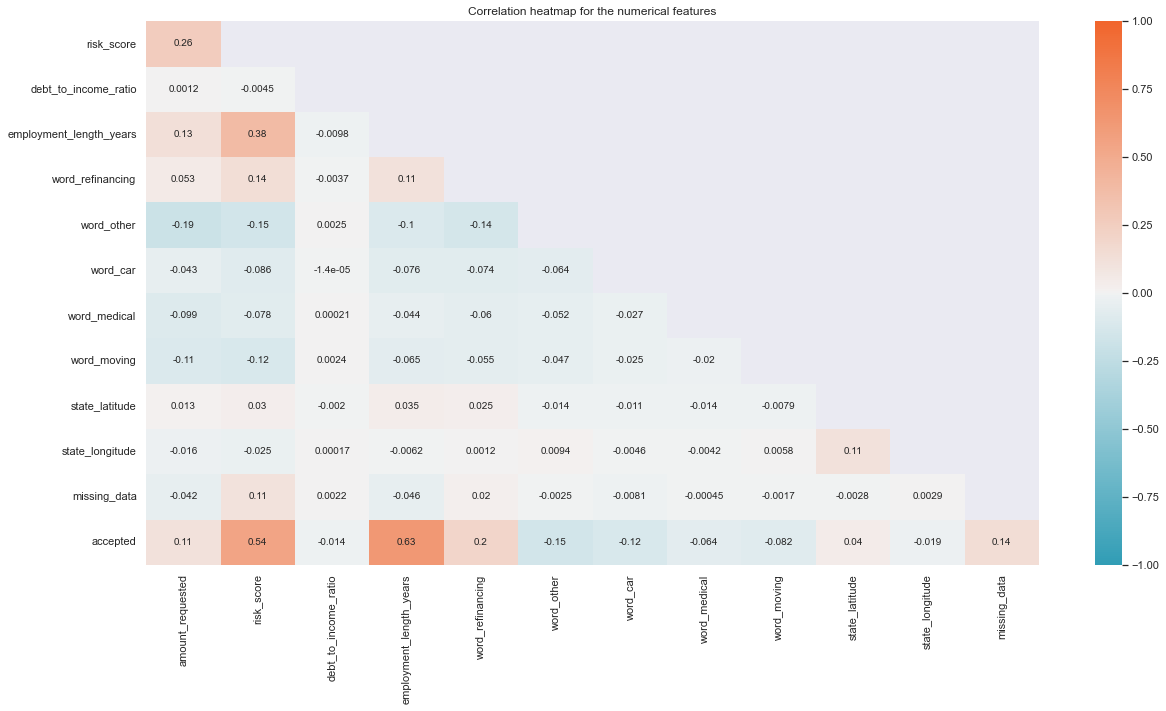

In [ ]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(cleaned_train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = cleaned_train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

In [ ]:
cleaned_train_set.groupby("employment_length_years")["risk_score"].mean()

employment_length_years
0.0     629.851196
1.0     692.005371
2.0     695.772278
3.0     696.698730
4.0     697.252380
5.0     688.215088
6.0     698.583130
7.0     699.000244
8.0     699.400940
9.0     699.647278
15.0    700.991516
Name: risk_score, dtype: float32

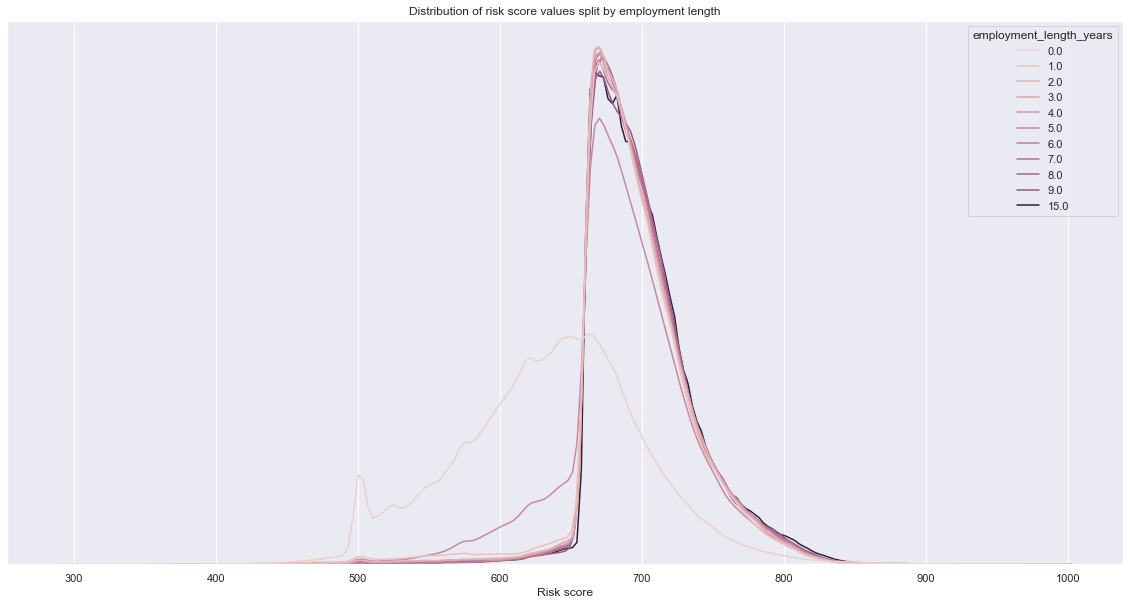

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=cleaned_train_set.join(train_accepted),
    x="risk_score",
    hue="employment_length_years",
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk score values split by employment length")
ax.set_yticks([])

plt.show()

In [ ]:
train_set = train_set.drop(train_set.loc[train_set["employment_length_years"].isna()].index)
test_set = test_set.drop(test_set.loc[test_set["employment_length_years"].isna()].index)

In [ ]:
print(f'mean | {cleaned_train_set["debt_to_income_ratio"].mean()}')
print(f'median | {cleaned_train_set["debt_to_income_ratio"].median()}')

NameError: name 'cleaned_train_set' is not defined

In [ ]:
train_set.median()["debt_to_income_ratio"]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_14256\1459107025.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_set.median()["debt_to_income_ratio"]


18.649999618530273

In [ ]:
to_log_list = ["debt_to_income_ratio", "amount_requested"]
preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(missing_dict, one_column = True)),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list))
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("downcast_numeric", DowncastNumeric())
    ]
)

cleaned_train_set = full_pipe.fit_transform(train_set)

In [ ]:
cleaned_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291501 entries, 262519 to 252772
Data columns (total 12 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   risk_score                float32
 1   employment_length_years   float32
 2   word_refinancing          int8   
 3   word_other                int8   
 4   word_car                  int8   
 5   word_medical              int8   
 6   word_moving               int8   
 7   state_latitude            float32
 8   state_longitude           float32
 9   missing_data              float32
 10  debt_to_income_ratio_log  float32
 11  amount_requested_log      float32
dtypes: float32(7), int8(5)
memory usage: 128.7 MB


In [ ]:
cleaned_train_set.isna().sum()

risk_score                  0
employment_length_years     0
word_refinancing            0
word_other                  0
word_car                    0
word_medical                0
word_moving                 0
state_latitude              0
state_longitude             0
missing_data                0
debt_to_income_ratio_log    0
amount_requested_log        0
dtype: int64

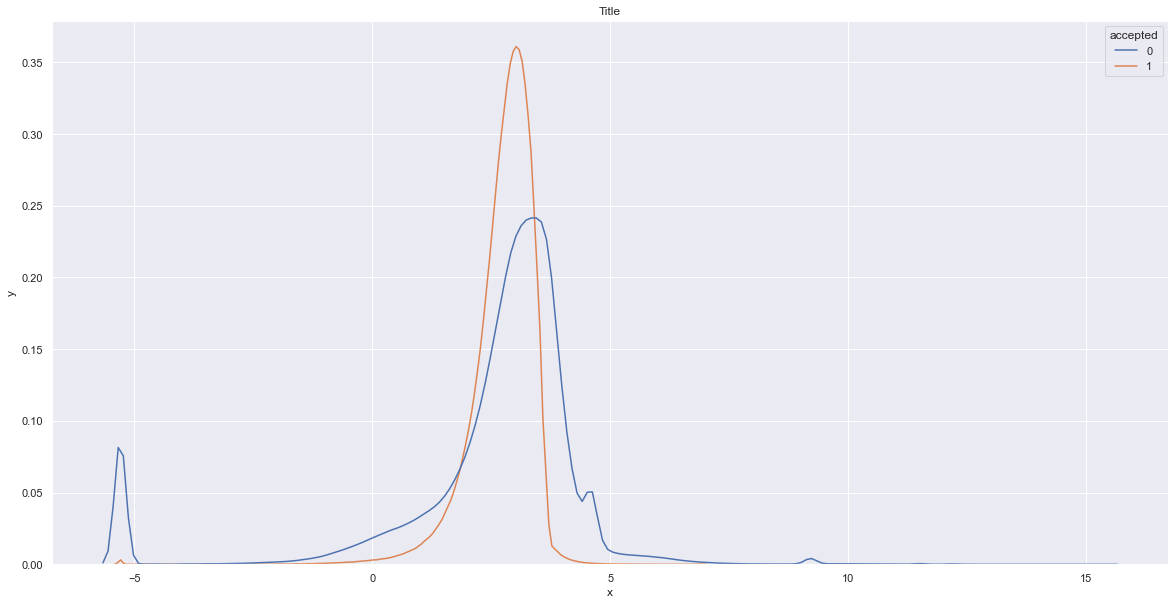

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=cleaned_train_set.join(train_accepted),
    x="debt_to_income_ratio_log",
    hue="accepted"
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

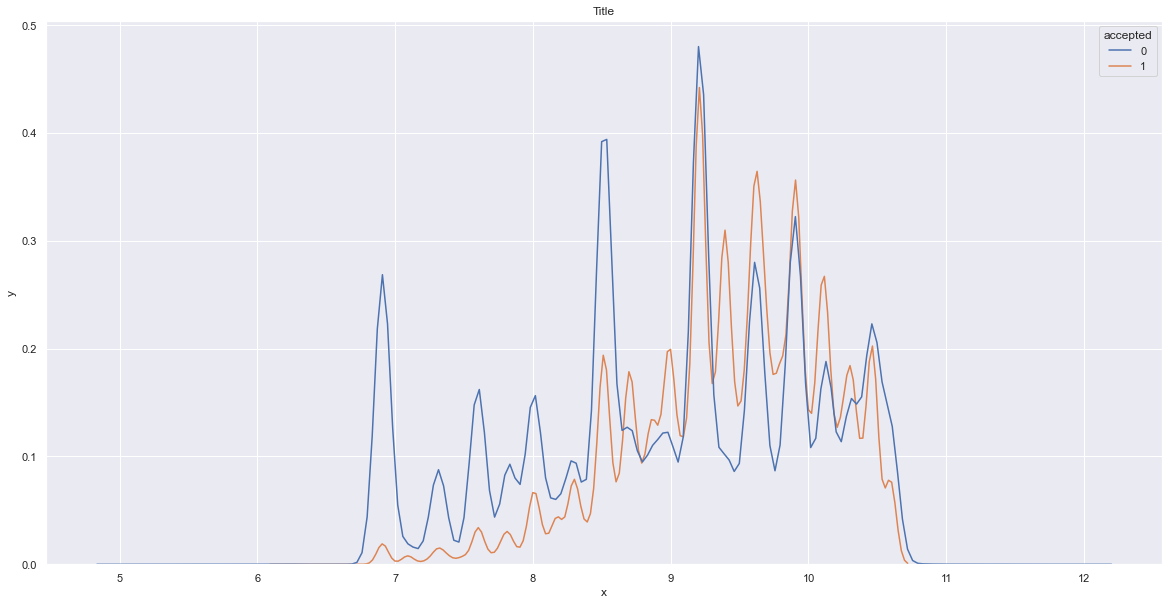

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=cleaned_train_set.join(train_accepted),
    x="amount_requested_log",
    hue="accepted"
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

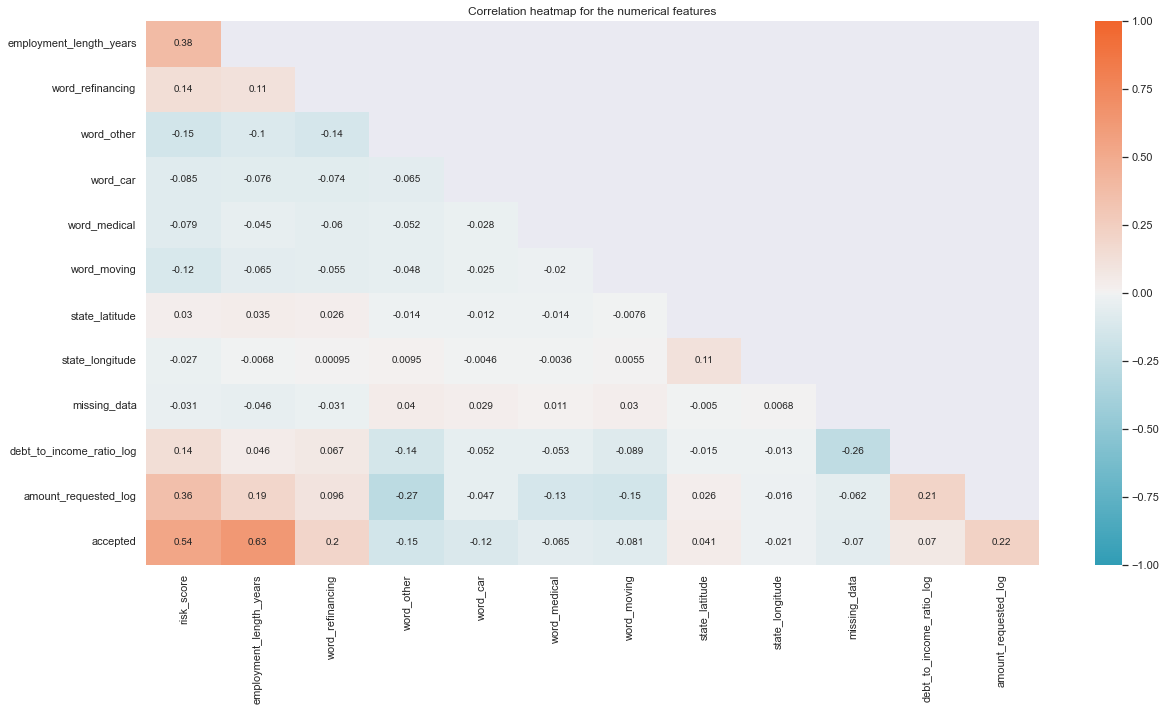

In [ ]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(cleaned_train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = cleaned_train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

In [ ]:
del(cleaned_train_set)

In [ ]:




#TODO: Do Data science magic





In [ ]:
del(cleaned_train_set)
del(df)
del(train_set)

In [ ]:
df = pd.read_csv('data/Loan_status_2007-2020Q3.gzip')

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_8912\1782016296.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Loan_status_2007-2020Q3.gzip')


In [ ]:
df_2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_8912\578772369.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


In [ ]:
df_2 = df_2.loc[df_2["id"].isin(df["id"])]

In [ ]:
df = df.loc[df["id"].isin(df_2["id"])]

In [ ]:
df = df.loc[df["id"].astype("str").str.isnumeric()]
df_2 = df_2.loc[df_2["id"].astype("str").str.isnumeric()]

In [ ]:
df_2  = df_2.set_index("id")
df = df.set_index("id")

In [ ]:
for column in df_2.columns:
    if column in df.columns:
        if not df_2[column].dtype == df[column].dtype:
            print("False", column)
    else:
        print("Not found", column)

Not found member_id
False int_rate
Not found desc
False revol_util
Not found sec_app_mths_since_last_major_derog
Not found disbursement_method
Not found debt_settlement_flag_date
Not found settlement_status
Not found settlement_date
Not found settlement_amount
Not found settlement_percentage
Not found settlement_term


In [ ]:
df.index = df.index.astype(int)
df_2.index = df_2.index.astype(int)

In [ ]:
df = df.sort_index()
df_2 = df_2.sort_index()

In [ ]:
original_columns = []
changed_columns = []
not_found_columns = []
for column in df_2.columns:
    if column in df.columns:
        if not df_2[column].dtype == df[column].dtype:
            df[column] = df[column].str.strip("%").astype("float")
        if df_2[column].equals(df[column]):
            original_columns.append(column)
        else:
            changed_columns.append(column)
    else:
        not_found_columns.append(column)

In [ ]:
del(df)
del(df_2)

In [ ]:
original_columns = ['loan_amnt', 'funded_amnt', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
                    'issue_d', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
                    'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
                    'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type',
                    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
                    'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
                    'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
                    'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
                    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 
                    'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
                    'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
                    'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
                    'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                    'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med']

In [18]:
df

loan_amnt  funded_amnt        term grade sub_grade  \
0           3600.0       3600.0   36 months     C        C4   
1          24700.0      24700.0   36 months     C        C1   
2          20000.0      20000.0   60 months     B        B4   
3          35000.0      35000.0   60 months     C        C5   
4          10400.0      10400.0   60 months     F        F1   
...            ...          ...         ...   ...       ...   
2260696    40000.0      40000.0   60 months     B        B3   
2260697    24000.0      24000.0   60 months     C        C4   
2260698    14000.0      14000.0   60 months     C        C4   
2260699        NaN          NaN         NaN   NaN       NaN   
2260700        NaN          NaN         NaN   NaN       NaN   

                           emp_title emp_length home_ownership  annual_inc  \
0                            leadman  10+ years       MORTGAGE     55000.0   
1                           Engineer  10+ years       MORTGAGE     65000.0   
2                       truck driver  10+ years       MORTGAGE     63000.0   
3        Information Systems Officer  10+ years       MORTGAGE    110000.0   
4                Contract Specialist    3 years       MORTGAGE    104433.0   
...                              ...        ...            ...         ...   
2260696              Vice President     9 years       MORTGAGE    227000.0   
2260697              Program Manager    6 years           RENT    110000.0   
2260698  Customer Service Technician  10+ years       MORTGAGE     95000.0   
2260699                          NaN        NaN            NaN         NaN   
2260700                          NaN        NaN            NaN         NaN   

        verification_status  ... sec_app_inq_last_6mths sec_app_mort_acc  \
0              Not Verified  ...                    NaN              NaN   
1              Not Verified  ...                    NaN              NaN   
2              Not Verified  ...                    NaN              NaN   
3           Source Verified  ...                    NaN              NaN   
4           Source Verified  ...                    NaN              NaN   
...                     ...  ...                    ...              ...   
2260696            Verified  ...                    NaN              NaN   
2260697        Not Verified  ...                    NaN              NaN   
2260698            Verified  ...                    NaN              NaN   
2260699                 NaN  ...                    NaN              NaN   
2260700                 NaN  ...                    NaN              NaN   

        sec_app_open_acc sec_app_revol_util sec_app_open_act_il  \
0                    NaN                NaN                 NaN   
1                    NaN                NaN                 NaN   
2                    NaN                NaN                 NaN   
3                    NaN                NaN                 NaN   
4                    NaN                NaN                 NaN   
...                  ...                ...                 ...   
2260696              NaN                NaN                 NaN   
2260697              NaN                NaN                 NaN   
2260698              NaN                NaN                 NaN   
2260699              NaN                NaN                 NaN   
2260700              NaN                NaN                 NaN   

        sec_app_num_rev_accts  sec_app_chargeoff_within_12_mths  \
0                         NaN                               NaN   
1                         NaN                               NaN   
2                         NaN                               NaN   
3                         NaN                               NaN   
4                         NaN                               NaN   
...                       ...                               ...   
2260696                   NaN                               NaN   
2260697                   NaN                               N

In [ ]:
df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_5784\4289167991.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


In [46]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", None)

In [82]:
titles = pd.read_excel("LCDataDictionary.xlsx")
titles = pd.DataFrame(titles.set_index("LoanStatNew").T)

FileNotFoundError: ignored

In [ ]:
titles = titles.loc[:, titles.columns[:-2]]

In [ ]:
df.head().append(titles).loc[:, not_found_columns]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_9968\3308183394.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(titles).loc[:, not_found_columns]


member_id  \
0                                                         NaN   
1                                                         NaN   
2                                                         NaN   
3                                                         NaN   
4                                                         NaN   
Description  A unique LC assigned Id for the borrower member.   

                                                  desc  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
Description  Loan description provided by the borrower   

             sec_app_mths_since_last_major_derog  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
Description                                  NaN   

                                                                                     disbursement_method  \
0                                                                                                   Cash   
1                                                                                                   Cash   
2                                                                                                   Cash   
3                                                                                                   Cash   
4                                                                                                   Cash   
Description  The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY   

                                                     debt_settlement_flag_date  \
0                                                                          NaN   
1                                                                          NaN   
2                                                                          NaN   
3                                                                          NaN   
4                                                                          NaN   
Description  The most recent date that the Debt_Settlement_Flag has been set     

                                                                                                                 settlement_status  \
0                                                                                                                              NaN   
1                                                                                                                              NaN   
2                                                                                                                              NaN   
3                                                                                                                              NaN   
4                                                                                                                              NaN   
Description  The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT   

                                                      settlement_date  \
0                                                                 NaN   
1                                                                 NaN   
2                                                                 NaN   
3                                                                 NaN   
4                                                                 NaN   
Description  The date that the borrower agrees to the settlement plan   

                                         

In [ ]:
df.loc[:, not_found_columns].isnull().sum()*100/ df.shape[0]

member_id                              100.000000
desc                                    94.423544
sec_app_mths_since_last_major_derog     98.410139
disbursement_method                      0.001460
debt_settlement_flag_date               98.485160
settlement_status                       98.485160
settlement_date                         98.485160
settlement_amount                       98.485160
settlement_percentage                   98.485160
settlement_term                         98.485160
dtype: float64

In [ ]:
df = df.loc[:, original_columns + ["disbursement_method", "int_rate"]]

In [ ]:
df.to_csv("original_columns.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 106 entries, loan_amnt to int_rate
dtypes: float64(87), object(19)
memory usage: 1.8+ GB


In [ ]:
missing_percentage = df.loc[:, original_columns].isnull().sum()*100/ df.shape[0]
missing_percentage[missing_percentage>40].sort_values()

mths_since_rcnt_il                    40.251099
il_util                               47.281042
mths_since_last_delinq                51.246715
mths_since_recent_revol_delinq        67.250910
mths_since_last_major_derog           74.309960
mths_since_recent_bc_dlq              77.011511
mths_since_last_record                84.113069
annual_inc_joint                      94.660506
dti_joint                             94.660683
verification_status_joint             94.880791
sec_app_num_rev_accts                 95.221792
sec_app_open_act_il                   95.221792
sec_app_open_acc                      95.221792
sec_app_mort_acc                      95.221792
sec_app_collections_12_mths_ex_med    95.221792
sec_app_earliest_cr_line              95.221792
sec_app_fico_range_high               95.221792
sec_app_fico_range_low                95.221792
sec_app_chargeoff_within_12_mths      95.221792
sec_app_inq_last_6mths                95.221792
revol_bal_joint                       95

In [ ]:
df.loc[:, df.columns[df.dtypes == "object"]].nunique()

term                              2
emp_title                    512694
emp_length                       11
home_ownership                    6
verification_status               3
issue_d                         139
purpose                          14
title                         63155
zip_code                        956
addr_state                       51
earliest_cr_line                754
initial_list_status               2
application_type                  2
verification_status_joint         3
sec_app_earliest_cr_line        663
disbursement_method               2
dtype: int64

In [ ]:
df.loc[:, df.columns[~(df.dtypes == "object")]].nunique().sort_values().head()

policy_code               1
num_tl_30dpd              5
sec_app_inq_last_6mths    7
num_tl_120dpd_2m          7
acc_now_delinq            9
dtype: int64

In [ ]:
(df["fico_range_high"] - df["fico_range_low"]).value_counts()

4.0    2260227
5.0        441
dtype: int64

In [ ]:
top_value_percentage = (df.loc[:, df.columns[~(df.dtypes == "string")]].apply(lambda x: x.value_counts().max(), axis=0)*100/df.shape[0])
top_value_percentage[top_value_percentage>50].sort_values()

title                         51.014840
purpose                       56.525697
inq_last_6mths                61.119184
initial_list_status           67.919950
term                          71.205967
num_accts_ever_120_pd         74.641273
delinq_2yrs                   81.351227
tot_coll_amt                  82.104135
pub_rec                       84.166725
pub_rec_bankruptcies          87.910033
num_tl_90g_dpd_24m            91.699875
num_tl_120dpd_2m              93.145356
application_type              94.659046
disbursement_method           96.542886
num_tl_30dpd                  96.632018
tax_liens                     97.135048
collections_12_mths_ex_med    98.336091
chargeoff_within_12_mths      99.232008
acc_now_delinq                99.608794
delinq_amnt                   99.679922
policy_code                   99.998540
dtype: float64

In [ ]:
df.isnull().sum().sort_values().head()

loan_amnt              33
disbursement_method    33
application_type       33
policy_code            33
initial_list_status    33
dtype: int64

In [ ]:
df.isna().all(axis=1).sum()

33

In [ ]:
def clean_data_2_1(df):
    
    df = df.drop(df[df.isna().all(axis=1)].index, axis=0)
    
    df["risk_score"] = (df["fico_range_high"] + df["fico_range_low"])/2
    df["sec_risk_score"] = (df["sec_app_fico_range_high"] + df["sec_app_fico_range_low"])/2
    df = df.drop(["fico_range_high", "fico_range_low", "sec_app_fico_range_high", "sec_app_fico_range_low", "title", "url", "funded_amnt"], axis=1)

    df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]] = df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]].astype("datetime64[D]")
    
    

    second_account_columns = (df.columns[df.columns.str.contains("sec")]).tolist()
    for column in second_account_columns:
        primary_column = column.replace("sec_app_", "")
        df[column] = df[column].fillna(df[primary_column])
        if df[column].dtype == "float":
            df[primary_column] = (df[primary_column] + df[column])/2
        else:
            df[primary_column] = df[primary_column] + ((df[primary_column] - df[column])/2)
        df = df.drop(column, axis=1)
    
    joint_columns = (df.columns[df.columns.str.contains("joint")]).tolist()
    for column in joint_columns:
        primary_column = column.replace("_joint", "")
        df[primary_column] = df[column].fillna(df[primary_column])
        df = df.drop(column, axis=1)
        
    top_value_percentage = (df.loc[:, df.columns[~(df.dtypes == "string")]].apply(lambda x: x.value_counts().max(), axis=0)*100/df.shape[0])
    df = df.drop(top_value_percentage[top_value_percentage>98].index, axis=1)
    
    return df

In [ ]:
df = clean_data_2_1(df)

In [ ]:
missing_percentage = df.isnull().sum()*100/ df.shape[0]
missing_percentage[missing_percentage>30].sort_values()

open_act_il                       38.312968
open_il_12m                       38.312968
open_il_24m                       38.312968
total_bal_il                      38.312968
inq_fi                            38.312968
open_rv_12m                       38.312968
open_rv_24m                       38.312968
max_bal_bc                        38.312968
inq_last_12m                      38.313012
total_cu_tl                       38.313012
open_acc_6m                       38.313012
all_util                          38.322655
mths_since_rcnt_il                40.250227
il_util                           47.280273
mths_since_last_delinq            51.246003
mths_since_recent_revol_delinq    67.250432
mths_since_last_major_derog       74.309585
mths_since_recent_bc_dlq          77.011175
mths_since_last_record            84.112837
dtype: float64

In [ ]:
titles = titles.drop(titles.columns[~titles.columns.isin(df.columns)], axis=1)

In [ ]:
df.head().append(titles)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11572\4213556082.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(titles)


loan_amnt  \
0                                                                                                                                                                                  3600.0   
1                                                                                                                                                                                 24700.0   
2                                                                                                                                                                                 20000.0   
3                                                                                                                                                                                 35000.0   
4                                                                                                                                                                                 10400.0   
Description  The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.   

                                                                                             term  \
0                                                                                       36 months   
1                                                                                       36 months   
2                                                                                       60 months   
3                                                                                       60 months   
4                                                                                       60 months   
Description  The number of payments on the loan. Values are in months and can be either 36 or 60.   

                              grade                  sub_grade  \
0                                 C                         C4   
1                                 C                         C1   
2                                 B                         B4   
3                                 C                         C5   
4                                 F                         F1   
Description  LC assigned loan grade  LC assigned loan subgrade   

                                                                       emp_title  \
0                                                                        leadman   
1                                                                       Engineer   
2                                                                   truck driver   
3                                                    Information Systems Officer   
4                                                            Contract Specialist   
Description  The job title supplied by the Borrower when applying for the loan.*   

                                                                                                                                     emp_length  \
0                                                                                                                                     10+ years   
1                                                                                                                                     10+ years   
2                                                                                                                                     10+ years   
3                                                                                                                                     10+ years   
4                                                                                                                                       3 years   
Description  Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.    

                                                              

In [20]:
del(df)

In [19]:
df2 = df.copy()

In [ ]:
df = df2

In [ ]:
def clean_data_2_2(df):
    df["emp_length"] = df["emp_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["emp_length"] = df["emp_length"].str.extract(r"([0-9]+)").astype("float")
    df = df.rename(columns={"emp_length" : "emp_length_years"})
    
    df["home_ownership"] = df["home_ownership"].str.lower()
    df = df.rename(columns={"addr_state":"state"})
    
    df["mths_since_earliest_cr_line"] = ((df["issue_d"] - df["earliest_cr_line"])/np.timedelta64(1, 'M')).round()
    df = df.drop("earliest_cr_line", axis=1)
    
    sub_grade = pd.Series(df["sub_grade"].dropna().unique()).sort_values(ascending=False).tolist()
    sub_grade_dict = {}
    grade_dict = {}
    num = 0
    for grade in sub_grade:
        sub_grade_dict[grade] = num
        if ((num == 4) | (num%5 == 4)):
            grade_dict[grade[0]] = num
        num += 1
        
    df["sub_grade"] = df["sub_grade"].replace(sub_grade_dict)
    df["grade"] = df["grade"].replace(grade_dict)
    
    corr_df = pd.DataFrame(columns = ["col1", "col2", "corr"])
    numeric_cols = df.columns[((df.dtypes == "float") | (df.dtypes == "int")) & (~df.columns.isin(["sub_grade", "int_rate", "grade"]))]
    for column in numeric_cols:
        if column in df.columns:
            col_corr = df.corrwith(df[column])
            multicoll_list = col_corr[(col_corr > 0.7) & (col_corr.index != column)].index.tolist()
            if multicoll_list:
                for corr in multicoll_list:
                    if np.abs(df[corr].corr(df["sub_grade"])) < np.abs(df[column].corr(df["sub_grade"])):
                        df = df.drop(corr, axis=1)
                    else:
                        df = df.drop(column, axis=1)
                        break
    
    df = df.convert_dtypes()
    
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    
    return df

In [ ]:
df = clean_data_2_2(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2260668 entries, 0 to 2260698
Data columns (total 57 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   loan_amnt               Int32         
 1   term                    string        
 2   grade                   Int8          
 3   sub_grade               Int8          
 4   emp_title               string        
 5   emp_length_years        Int8          
 6   home_ownership          string        
 7   annual_inc              Float32       
 8   verification_status     string        
 9   issue_d                 datetime64[ns]
 10  purpose                 string        
 11  zip_code                string        
 12  state                   string        
 13  dti                     Float32       
 14  delinq_2yrs             Int8          
 15  inq_last_6mths          Float32       
 16  mths_since_last_delinq  Int16         
 17  mths_since_last_record  Int16         
 18  pu

In [ ]:
df.head().append(titles)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11572\4213556082.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(titles)


loan_amnt  \
0                                                                                                                                                                                    3600   
1                                                                                                                                                                                   24700   
2                                                                                                                                                                                   20000   
3                                                                                                                                                                                   35000   
4                                                                                                                                                                                   10400   
Description  The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.   

                                                                                             term  \
0                                                                                       36 months   
1                                                                                       36 months   
2                                                                                       60 months   
3                                                                                       60 months   
4                                                                                       60 months   
Description  The number of payments on the loan. Values are in months and can be either 36 or 60.   

                              grade                  sub_grade  \
0                                 C                         21   
1                                 C                         24   
2                                 B                         26   
3                                 C                         20   
4                                 F                          9   
Description  LC assigned loan grade  LC assigned loan subgrade   

                                                                       emp_title  \
0                                                                        leadman   
1                                                                       Engineer   
2                                                                   truck driver   
3                                                    Information Systems Officer   
4                                                            Contract Specialist   
Description  The job title supplied by the Borrower when applying for the loan.*   

             emp_length_years  \
0                          15   
1                          15   
2                          15   
3                          15   
4                           3   
Description              <NA>   

                                                                                                                                                    home_ownership  \
0                                                                                                                                                         mortgage   
1                                                                                                                                                         mortgage   
2                                                                                                                                                         mortgage   
3                                                                                                                                                         mortgage   
4                             

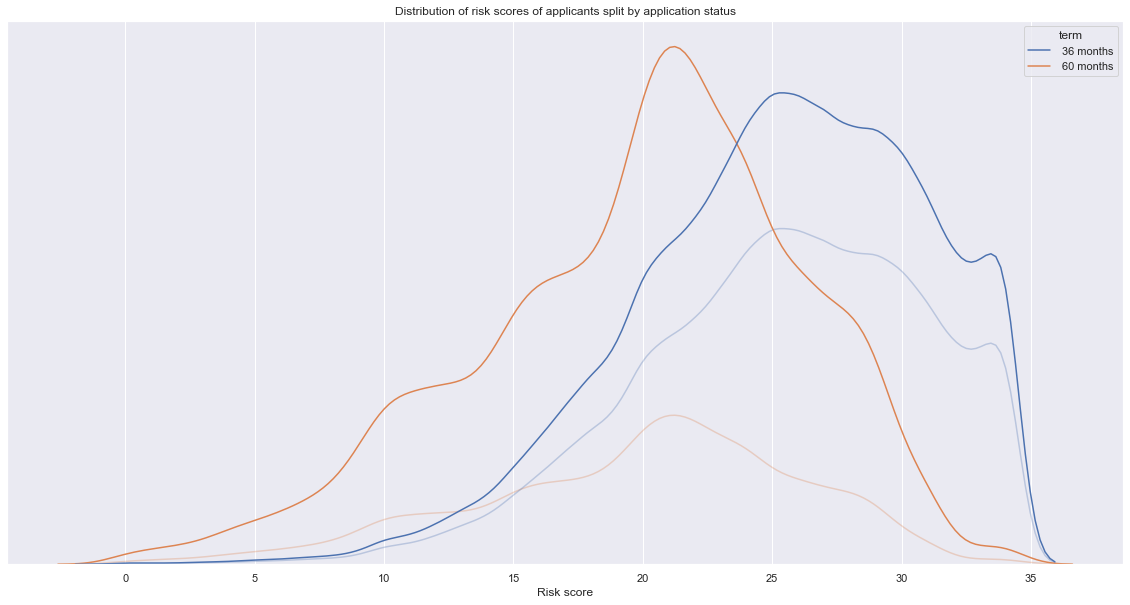

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="term",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="term",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

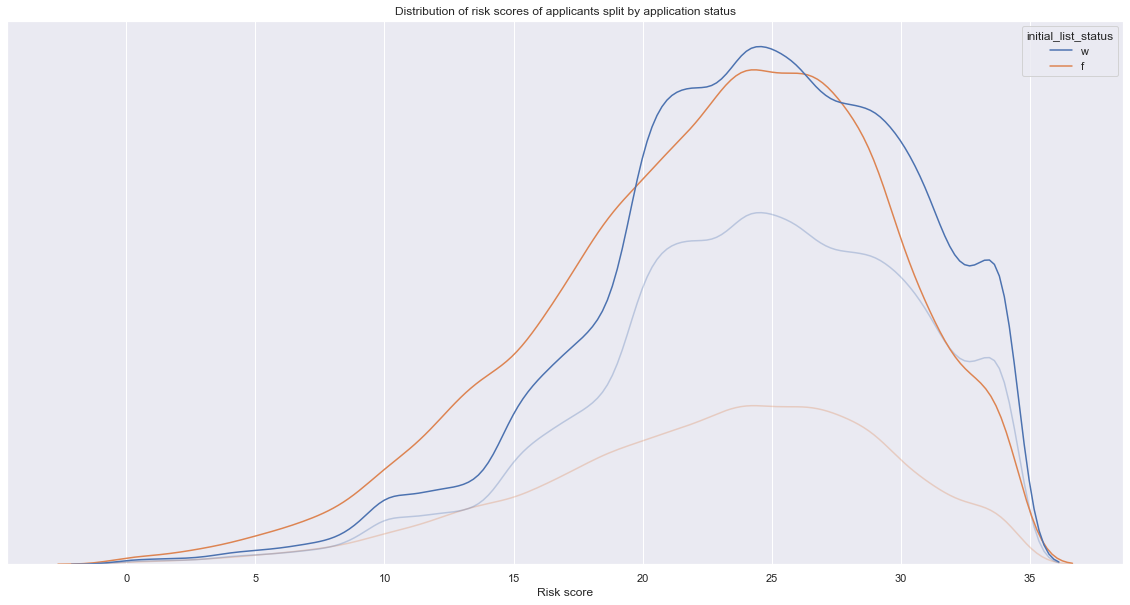

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="initial_list_status",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="initial_list_status",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

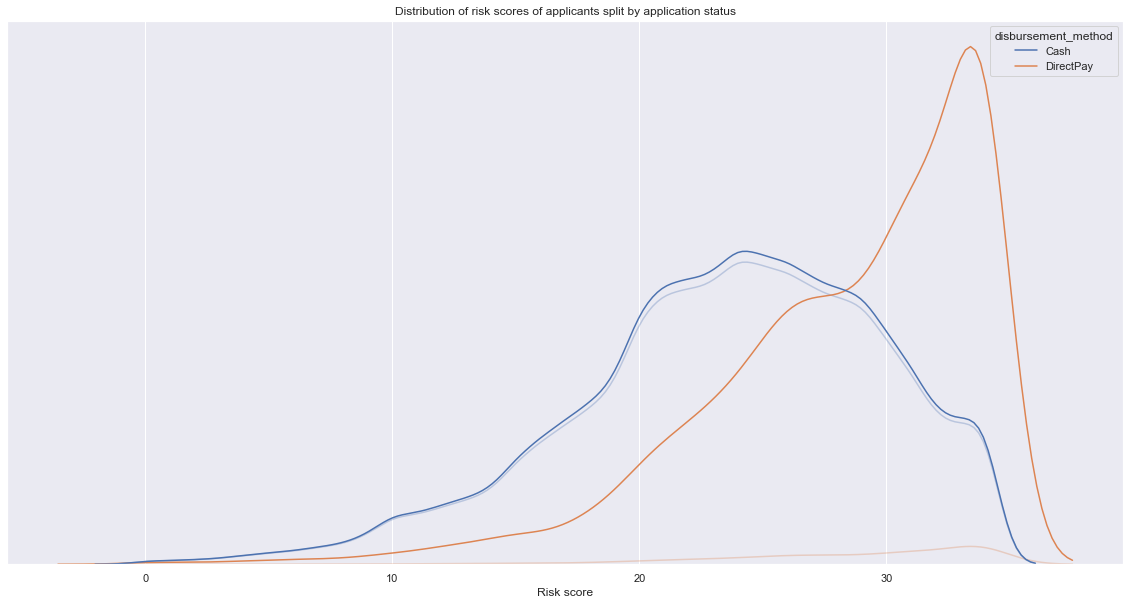

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="disbursement_method",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="disbursement_method",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

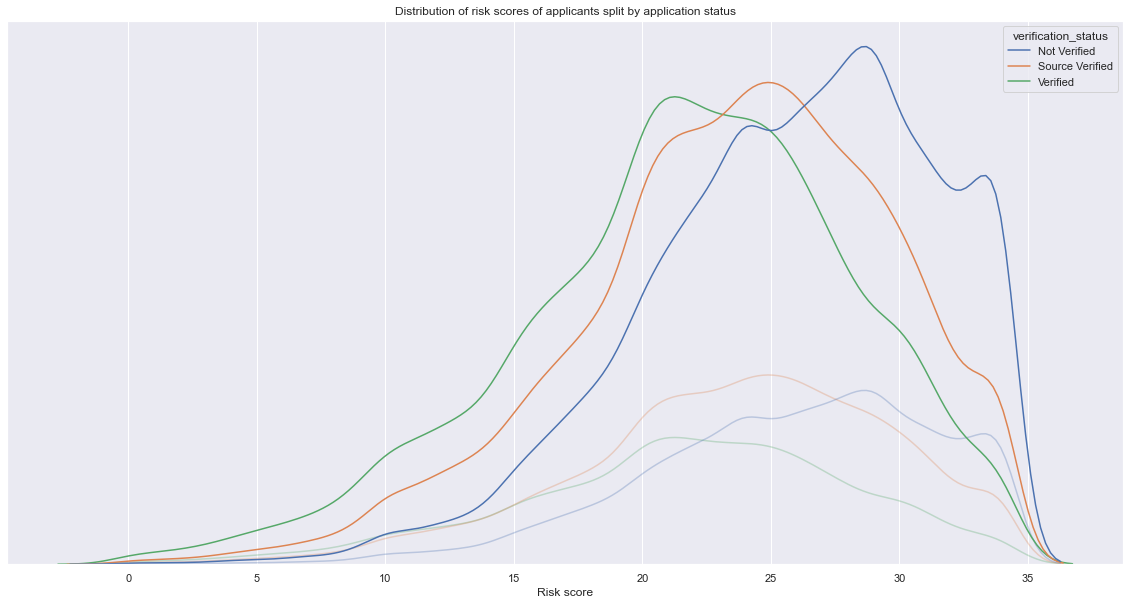

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="verification_status",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="verification_status",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [ ]:
df["purpose"].value_counts()*100/df.shape[0]

debt_consolidation    56.526522
credit_card           22.868064
home_improvement       6.655422
other                  6.168088
major_purchase          2.23142
medical                1.215924
small_business         1.092111
car                    1.062208
vacation               0.686744
moving                 0.681347
house                  0.625302
wedding                0.104173
renewable_energy       0.063919
educational            0.018756
Name: purpose, dtype: Float64

In [ ]:
largest_purposes = df["purpose"].value_counts()[(df["purpose"].value_counts()*100/df.shape[0])>5].index
temp_df = df.loc[df["purpose"].isin(largest_purposes), ["purpose", "sub_grade"]]

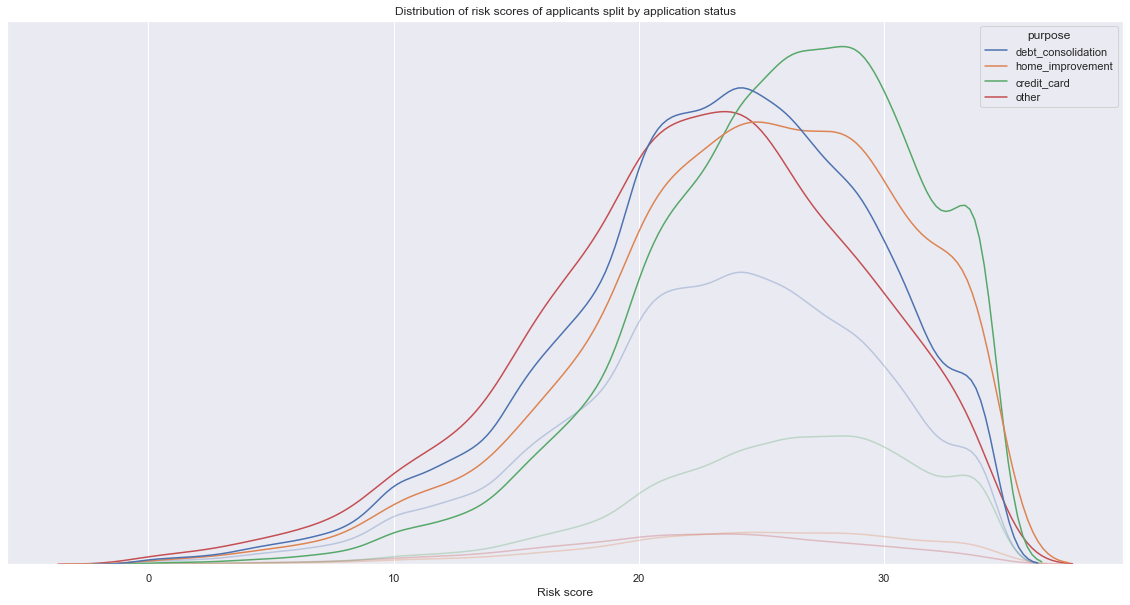

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="purpose",
    palette=[colors["blue"], colors["orange"], colors["green"], colors["red"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="purpose",
    palette=[colors["blue"], colors["orange"], colors["green"], colors["red"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [ ]:




#TODO: Explore employee title





In [ ]:
df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_5784\1404742926.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')


In [ ]:
prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_5784\3180300157.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")


In [ ]:
prof_df

total
manager                      305627
director                      80439
assistant                     72743
sales                         72215
supervisor                    58337
...                             ...
handlerhazmat                     1
operataions                       1
manufacturingadministration       1
insigh                            1
scienrist                         1

[97620 rows x 1 columns]

In [ ]:
word_dict = {"tech":"technician", "sr":"senior", "rn":"registered nurse", "vp":"vice president", "rep":"representative", 
             "lead":"senior", "health care":"nurse", "chief":"senior", "admin":"administrator", "administrative":"administrator", 
             "asst":"assistant", "mgr":"manager", "human resources":"hr", "professor":"teacher", "cook":"chef"} 

In [ ]:
for key in word_dict.keys():
    df["emp_title"] = df["emp_title"].str.replace(fr"(?:^|\W){key}(?:$|\W)", word_dict[key], regex=True)

In [ ]:
employees_count = employees.value_counts()

In [ ]:
 word_df = pd.Series([y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]).value_counts().to_frame("total")
    word_df["total"] = (word_df["total"]/word_df["total"].sum()).round(3)
    for index, value in enumerate(["rejected", "accepted"]):
        word_df[value] = pd.Series([y for x in df.loc[target == index, "loan_title"].dropna().values.flatten() for y in x.split()]).value_counts()
        word_df[value] = (word_df[value]/word_df[value].sum()).round(3)
        
        

    word_df = pd.DataFrame(index=df.index)
    for word in difference_words:
        word_df.loc[df["loan_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), word] = 1
        word_df.loc[:, word] = word_df.loc[:, word].fillna(0).astype(int)

        word_corr = word_df.corrwith(word_df[word])
        multicoll_list = word_corr[(word_corr > 0.7) & (word_corr.index != word)].index.tolist()
        if multicoll_list:
            for multicoll_name in multicoll_list:
                if np.abs(word_df[multicoll_name].corr(target)) < np.abs(word_df[word].corr(target)):
                    word_df = word_df.drop(multicoll_name, axis=1)
                else:
                    word_df = word_df.drop(word, axis=1)

In [ ]:
df["emp_title"]

0                              leadman
1                             engineer
2                         truck driver
3          information systems officer
4                  contract specialist
                      ...             
2260694                  unit operator
2260695         database administrator
2260696                vice president 
2260697                program manager
2260698    customer service technician
Name: emp_title, Length: 2260668, dtype: string

In [ ]:
words_one_hot = df.loc[:, ["emp_title", "sub_grade"]]

In [ ]:
prof_df.head(20).index.tolist()

['manager',
 'director',
 'assistant',
 'sales',
 'supervisor',
 'teacher',
 'specialist',
 'of',
 'senior',
 'engineer',
 'driver',
 'analyst',
 'nurse',
 'service',
 'officer',
 'technician',
 'owner',
 'tech',
 'coordinator',
 'operations']

In [ ]:
num = 0
corr_words = pd.Series(name = "correlation")
for word in prof_df.head(400).index.tolist():
    num += 1
    print(f'{num}/400 - {word}')
    words_one_hot = df.loc[:, ["emp_title", "sub_grade"]]
    
    words_one_hot.loc[words_one_hot["emp_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), "word"] = 1
    words_one_hot.loc[:, "word"] = words_one_hot.loc[:, "word"].fillna(0).astype(int)
    corr_words[word] = words_one_hot["word"].corr(words_one_hot["sub_grade"].astype("float"))

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_5784\1770033099.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_words = pd.Series(name = "correlation")


1/400 - manager
2/400 - director
3/400 - assistant
4/400 - sales
5/400 - supervisor
6/400 - teacher
7/400 - specialist
8/400 - of
9/400 - senior
10/400 - engineer
11/400 - driver
12/400 - analyst
13/400 - nurse
14/400 - service
15/400 - officer
16/400 - technician
17/400 - owner
18/400 - tech
19/400 - coordinator
20/400 - operations
21/400 - operator
22/400 - sr
23/400 - project
24/400 - president
25/400 - registered
26/400 - associate
27/400 - office
28/400 - lead
29/400 - executive
30/400 - rn
31/400 - business
32/400 - consultant
33/400 - general
34/400 - account
35/400 - it
36/400 - customer
37/400 - and
38/400 - administrator
39/400 - clerk
40/400 - services
41/400 - medical
42/400 - vice
43/400 - support
44/400 - truck
45/400 - maintenance
46/400 - program
47/400 - administrative
48/400 - accountant
49/400 - financial
50/400 - systems
51/400 - inc
52/400 - mechanic
53/400 - security
54/400 - software
55/400 - management
56/400 - marketing
57/400 - agent
58/400 - production
59/400

In [ ]:
words_one_hot = words_one_hot.drop("emp_title", axis=1)

In [ ]:
bad_careers = corr_words.sort_values().head(20).index.tolist()
good_careers = corr_words.sort_values(ascending=False).head(20).index.tolist()

In [ ]:
words_one_hot_bad = df.loc[:, ["emp_title", "sub_grade"]]


num = 0
for word in bad_careers:
    num += 1
    print(f'{num}/400 - {word}')
    words_one_hot_bad.loc[words_one_hot_bad["emp_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), "good_careers"] = 1
words_one_hot_bad.loc[:, "good_careers"] = words_one_hot_bad.loc[:, "good_careers"].fillna(0).astype(int)

words_one_hot_bad["good_careers"].corr(words_one_hot_bad["sub_grade"].astype("float"))

1/400 - driver
2/400 - operator
3/400 - supervisor
4/400 - clerk
5/400 - army
6/400 - service
7/400 - truck
8/400 - customer
9/400 - us
10/400 - assistant
11/400 - technician
12/400 - warehouse
13/400 - cna
14/400 - cashier
15/400 - processor
16/400 - machine
17/400 - bus
18/400 - banker
19/400 - teller
20/400 - mechanic
21/400 - mortgage
22/400 - handler
23/400 - loan
24/400 - store
25/400 - care
26/400 - aide
27/400 - correctional
28/400 - medical
29/400 - forklift
30/400 - patient
31/400 - security
32/400 - home
33/400 - branch
34/400 - worker
35/400 - shift
36/400 - receiving
37/400 - welder
38/400 - front
39/400 - laborer2
40/400 - laborer


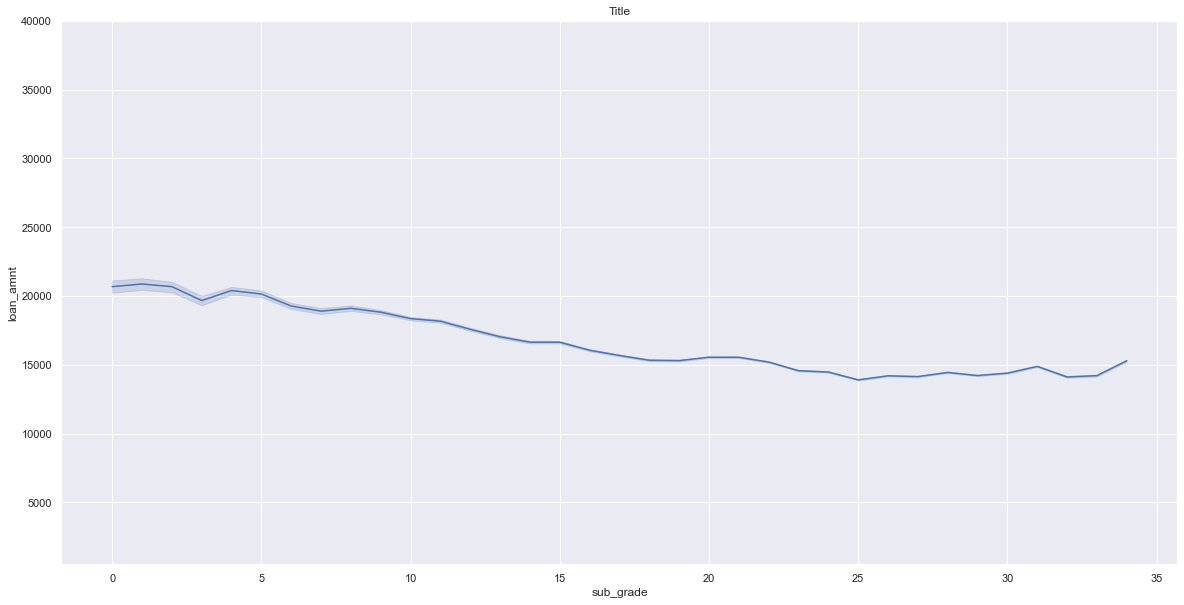

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="loan_amnt",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["loan_amnt"].min(), df["loan_amnt"].max()])
plt.show()

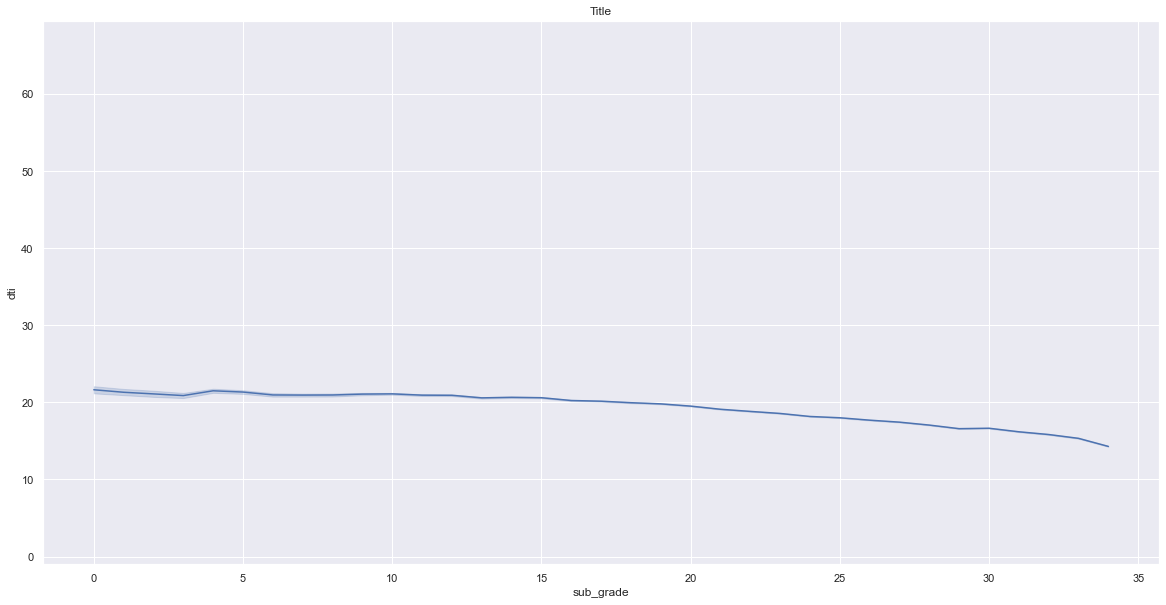

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="dti",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["dti"].min(), df["dti"].max()])
plt.show()

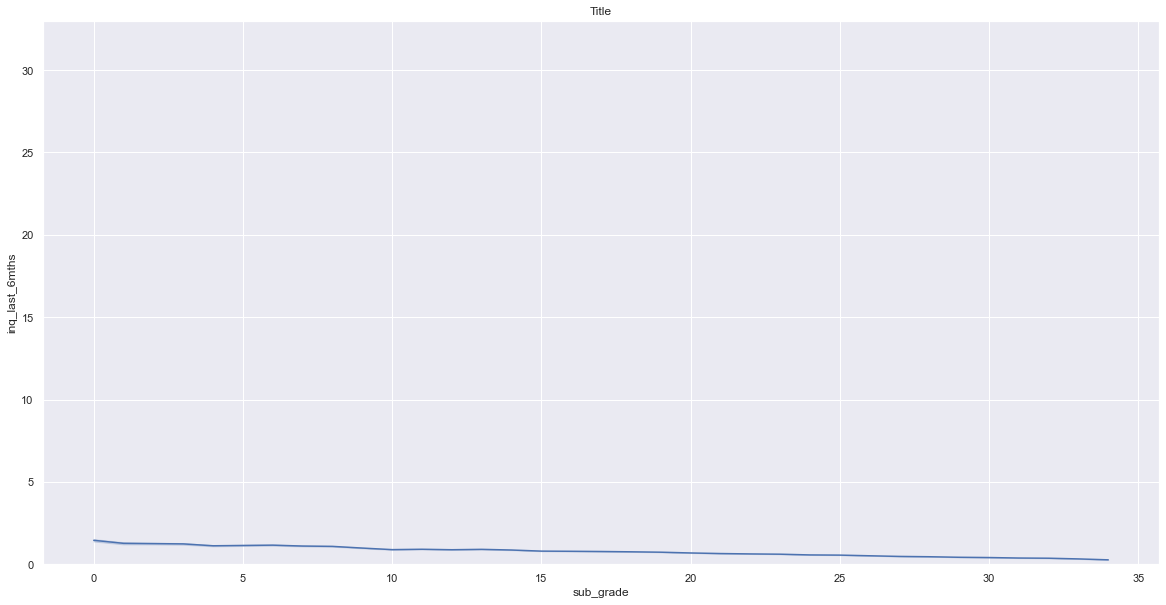

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="inq_last_6mths",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["inq_last_6mths"].min(), df["inq_last_6mths"].max()])
plt.show()

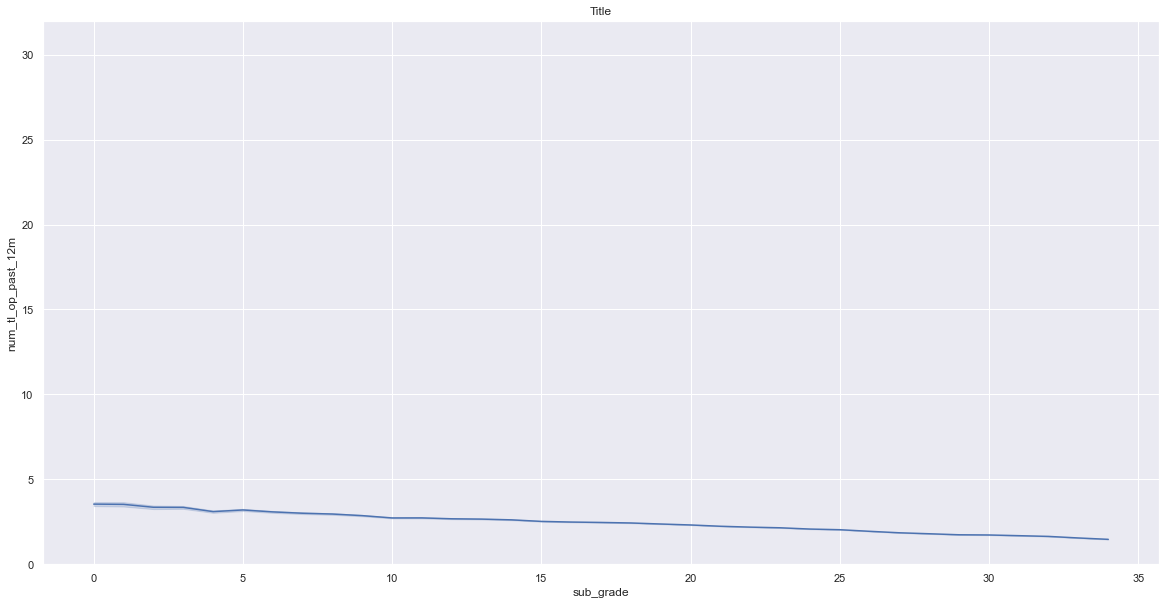

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="num_tl_op_past_12m",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["num_tl_op_past_12m"].min(), df["num_tl_op_past_12m"].max()])
plt.show()

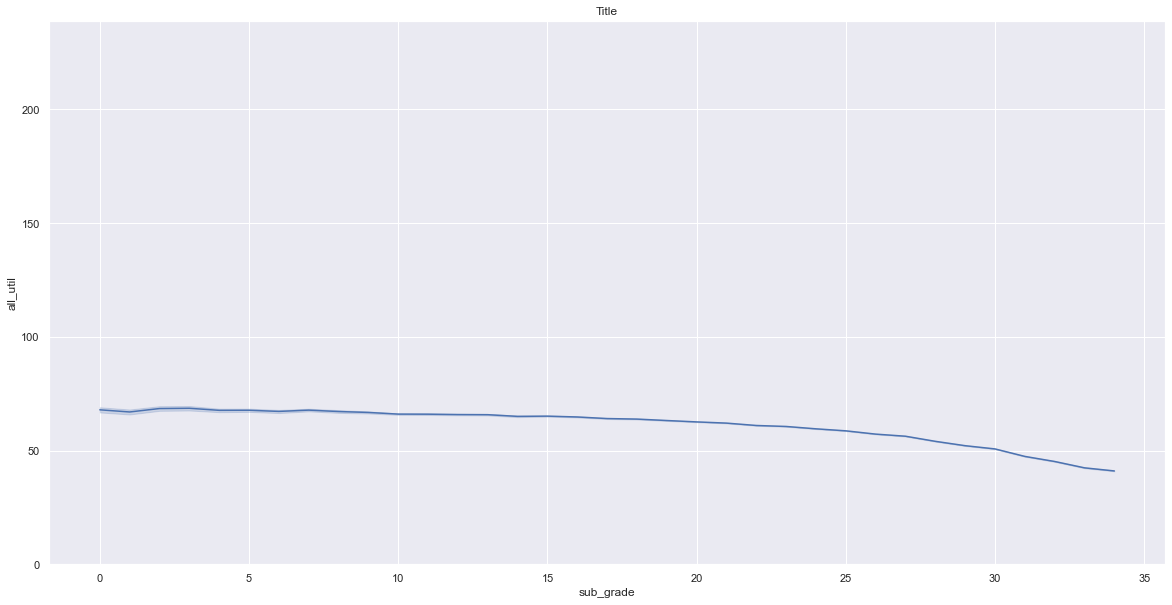

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="all_util",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["all_util"].min(), df["all_util"].max()])
plt.show()

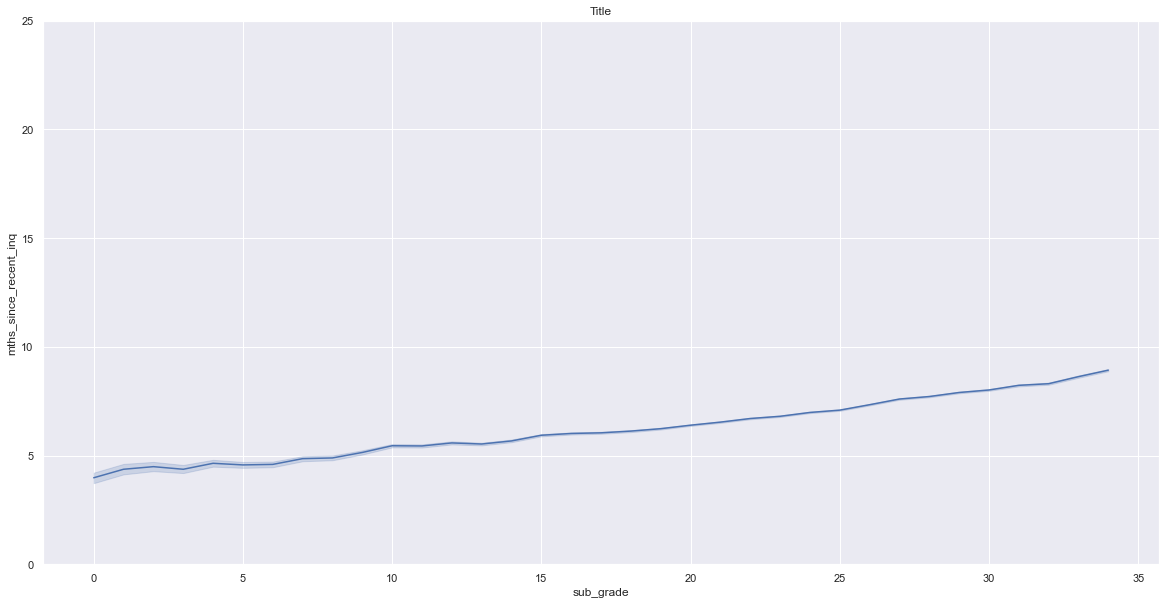

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="mths_since_recent_inq",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["mths_since_recent_inq"].min(), df["mths_since_recent_inq"].max()])
plt.show()

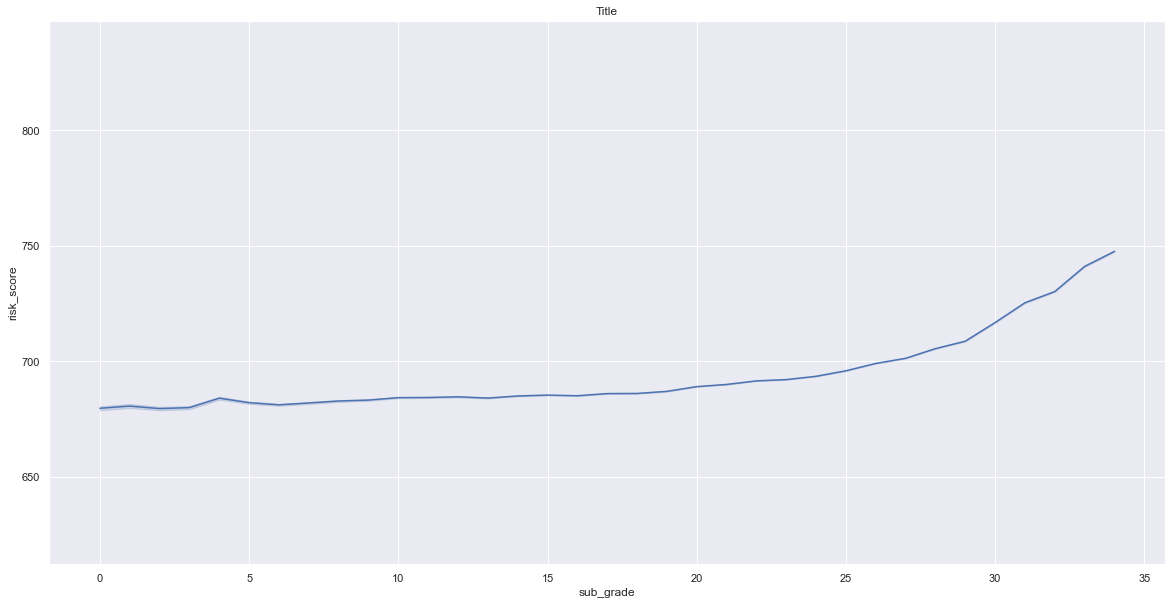

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="risk_score",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["risk_score"].min(), df["risk_score"].max()])
plt.show()

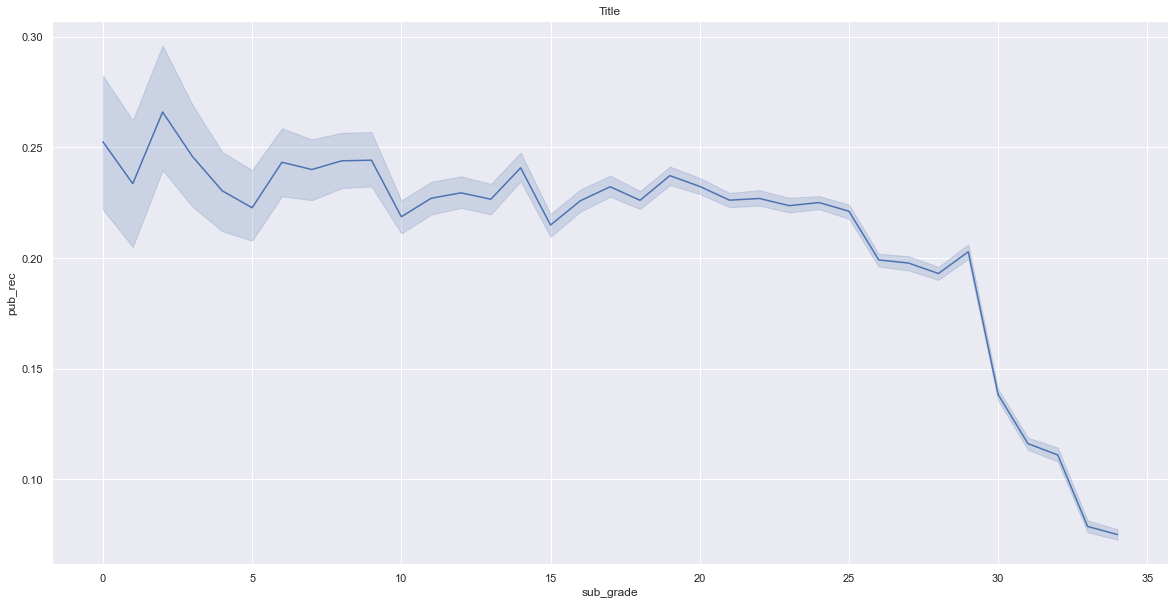

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="pub_rec",
    markers=True
)
ax.set_title("Title")
plt.show()

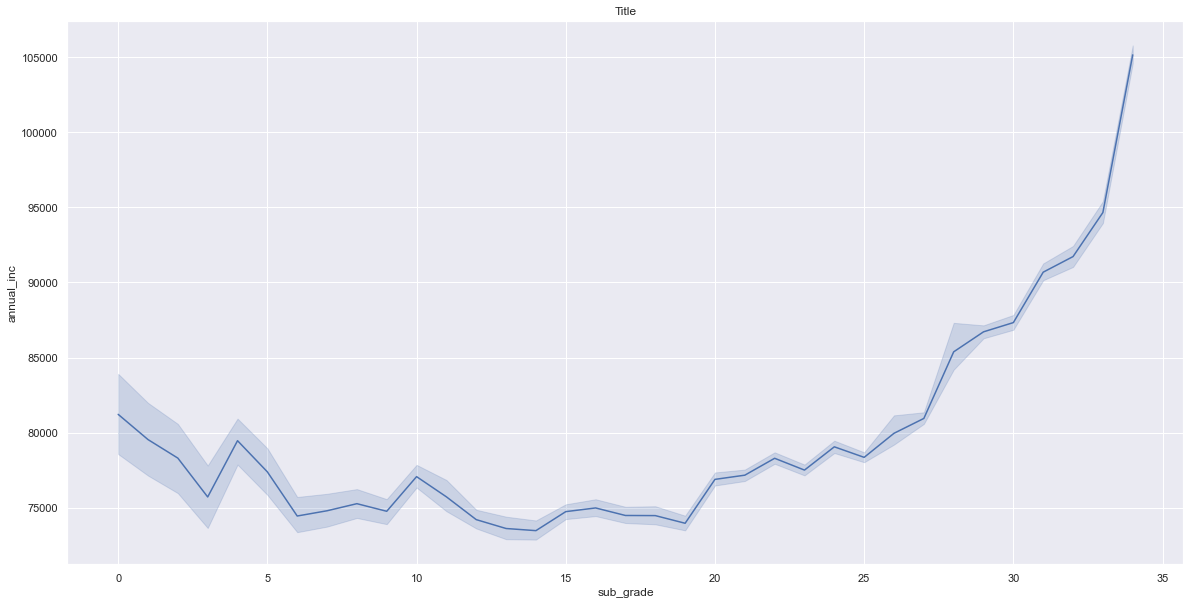

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="annual_inc",
    markers=True
)
ax.set_title("Title")
plt.show()

In [ ]:
df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_5784\3975796305.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


In [ ]:
df2 = df2.loc[:, original_columns]

In [ ]:
df.head().append(titles)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_5784\4213556082.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(titles)


loan_amnt  \
0                                                                                                                                                                                    3600   
1                                                                                                                                                                                   24700   
2                                                                                                                                                                                   20000   
3                                                                                                                                                                                   35000   
4                                                                                                                                                                                   10400   
Description  The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.   

                                                                                             term  \
0                                                                                       36 months   
1                                                                                       36 months   
2                                                                                       60 months   
3                                                                                       60 months   
4                                                                                       60 months   
Description  The number of payments on the loan. Values are in months and can be either 36 or 60.   

                              grade                  sub_grade  \
0                                24                         21   
1                                24                         24   
2                                29                         26   
3                                24                         20   
4                                 9                          9   
Description  LC assigned loan grade  LC assigned loan subgrade   

                                                                       emp_title  \
0                                                                        leadman   
1                                                                       engineer   
2                                                                   truck driver   
3                                                    information systems officer   
4                                                            contract specialist   
Description  The job title supplied by the Borrower when applying for the loan.*   

             emp_length_years  \
0                          15   
1                          15   
2                          15   
3                          15   
4                           3   
Description              <NA>   

                                                                                                                                                    home_ownership  \
0                                                                                                                                                         mortgage   
1                                                                                                                                                         mortgage   
2                                                                                                                                                         mortgage   
3                                                                                                                                                         mortgage   
4                             

In [10]:
df2

loan_amnt  funded_amnt        term  grade  sub_grade  \
0           3600.0       3600.0   36 months     24         21   
1          24700.0      24700.0   36 months     24         24   
2          20000.0      20000.0   60 months     29         26   
3          35000.0      35000.0   60 months     24         20   
4          10400.0      10400.0   60 months      9          9   
...            ...          ...         ...    ...        ...   
2260694    24000.0      24000.0   60 months     24         24   
2260695    24000.0      24000.0   60 months     29         27   
2260696    40000.0      40000.0   60 months     29         27   
2260697    24000.0      24000.0   60 months     24         21   
2260698    14000.0      14000.0   60 months     24         21   

                           emp_title  emp_length_years home_ownership  \
0                            leadman              15.0       mortgage   
1                           Engineer              15.0       mortgage   
2                       truck driver              15.0       mortgage   
3        Information Systems Officer              15.0       mortgage   
4                Contract Specialist               3.0       mortgage   
...                              ...               ...            ...   
2260694                Unit Operator               7.0       mortgage   
2260695       Database Administrator              15.0       mortgage   
2260696              Vice President                9.0       mortgage   
2260697              Program Manager               6.0           rent   
2260698  Customer Service Technician              15.0       mortgage   

         annual_inc verification_status  ... sec_app_revol_util  \
0           55000.0        Not Verified  ...                NaN   
1           65000.0        Not Verified  ...                NaN   
2           63000.0        Not Verified  ...                NaN   
3          110000.0     Source Verified  ...                NaN   
4          104433.0     Source Verified  ...                NaN   
...             ...                 ...  ...                ...   
2260694     95000.0     Source Verified  ...                NaN   
2260695    108000.0        Not Verified  ...                NaN   
2260696    227000.0            Verified  ...                NaN   
2260697    110000.0        Not Verified  ...                NaN   
2260698     95000.0            Verified  ...                NaN   

        sec_app_open_act_il sec_app_num_rev_accts  \
0                       NaN                   NaN   
1                       NaN                   NaN   
2                       NaN                   NaN   
3                       NaN                   NaN   
4                       NaN                   NaN   
...                     ...                   ...   
2260694                 NaN                   NaN   
2260695                 NaN                   NaN   
2260696                 NaN                   NaN   
2260697                 NaN                   NaN   
2260698                 NaN                   NaN   

        sec_app_chargeoff_within_12_mths  sec_app_collections_12_mths_ex_med  \
0                                    NaN                                 NaN   
1                                    NaN                                 NaN   
2                                    NaN                                 NaN   
3                                    NaN                                 NaN   
4                                    NaN                                 NaN   
...                                  ...                                 ...   
2260694                              NaN                                 NaN   
2260695                              NaN                                 NaN   
2260696                              NaN                                 NaN   
2260697                              NaN                                 NaN   
2260698                      

In [8]:
def function_1(df):
    df = df.drop(df[df.isna().all(axis=1)].index, axis=0)
    
    df["risk_score"] = (df["fico_range_high"] + df["fico_range_low"])/2
    df["sec_risk_score"] = (df["sec_app_fico_range_high"] + df["sec_app_fico_range_low"])/2
    df = df.drop(["fico_range_high", "fico_range_low", "sec_app_fico_range_high", "sec_app_fico_range_low", "title", "url"], axis=1)

    df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]] = df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]].astype("datetime64[D]")
    df["emp_length"] = df["emp_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["emp_length"] = df["emp_length"].str.extract(r"([0-9]+)").astype("float")
    df = df.rename(columns={"emp_length" : "emp_length_years"})
    
    df["home_ownership"] = df["home_ownership"].str.lower()
    df = df.rename(columns={"addr_state":"state"})
    
    df["mths_since_earliest_cr_line"] = ((df["issue_d"] - df["earliest_cr_line"])/np.timedelta64(1, 'M')).round()
    df = df.drop("earliest_cr_line", axis=1)
    
    sub_grade = pd.Series(df["sub_grade"].dropna().unique()).sort_values(ascending=False).tolist()
    sub_grade_dict = {}
    grade_dict = {}
    num = 0
    for grade in sub_grade:
        sub_grade_dict[grade] = num
        if ((num == 4) | (num%5 == 4)):
            grade_dict[grade[0]] = num
        num += 1
        
    df["sub_grade"] = df["sub_grade"].replace(sub_grade_dict)
    df["grade"] = df["grade"].replace(grade_dict)    
    
    return df

In [9]:
df2 = function_1(df2)

In [ ]:
missing_values = df.isna().sum().sort_values(ascending=False)

In [ ]:
missing_values

mths_since_last_record    1901512
mths_since_last_delinq    1158502
il_util                   1068850
mths_since_rcnt_il         909924
all_util                   866348
inq_last_12m               866130
total_cu_tl                866130
inq_fi                     866129
max_bal_bc                 866129
total_bal_il               866129
open_il_12m                866129
open_act_il                866129
mths_since_recent_inq      295435
emp_title                  166969
num_tl_120dpd_2m           153657
emp_length_years           146907
mo_sin_old_il_acct         139071
bc_util                     76071
bc_open_to_buy              74935
mths_since_recent_bc        73412
pct_tl_nvr_dlq              70431
mo_sin_rcnt_rev_tl_op       70277
mo_sin_old_rev_tl_op        70277
num_tl_op_past_12m          70276
num_tl_90g_dpd_24m          70276
num_actv_rev_tl             70276
num_accts_ever_120_pd       70276
mo_sin_rcnt_tl              70276
num_bc_tl                   70276
tot_hi_cred_li

In [ ]:
missing_values = missing_values[missing_values>1000].index.tolist()

In [74]:
missing_values = ["il_util", "all_util", "inq_last_12m", "total_cu_tl", "inq_fi", "max_bal_bc", 
                  "total_bal_il", "open_il_12m","open_act_il", "num_tl_120dpd_2m", 
                  "emp_length_years", "bc_util", "bc_open_to_buy", "pct_tl_nvr_dlq", "num_tl_op_past_12m", 
                  "num_tl_90g_dpd_24m", "num_actv_rev_tl", "num_accts_ever_120_pd", "num_bc_tl", 
                  "tot_hi_cred_lim","num_il_tl", "tot_coll_amt", "num_tl_30dpd", "num_sats", "mort_acc", "pub_rec_bankruptcies"]

In [ ]:
df2.dtypes

loan_amnt                                    float64
funded_amnt                                  float64
term                                          object
grade                                          int64
sub_grade                                      int64
emp_title                                     object
emp_length_years                             float64
home_ownership                                object
annual_inc                                   float64
verification_status                           object
issue_d                               datetime64[ns]
purpose                                       object
zip_code                                      object
state                                         object
dti                                          float64
delinq_2yrs                                  float64
inq_last_6mths                               float64
mths_since_last_delinq                       float64
mths_since_last_record                       f

In [ ]:
df2.loc[:, df2.columns[df2.dtypes == "float"]]

loan_amnt  funded_amnt  emp_length_years  annual_inc    dti  \
0           3600.0       3600.0              15.0     55000.0   5.91   
1          24700.0      24700.0              15.0     65000.0  16.06   
2          20000.0      20000.0              15.0     63000.0  10.78   
3          35000.0      35000.0              15.0    110000.0  17.06   
4          10400.0      10400.0               3.0    104433.0  25.37   
...            ...          ...               ...         ...    ...   
2260694    24000.0      24000.0               7.0     95000.0  19.61   
2260695    24000.0      24000.0              15.0    108000.0  34.94   
2260696    40000.0      40000.0               9.0    227000.0  12.75   
2260697    24000.0      24000.0               6.0    110000.0  18.30   
2260698    14000.0      14000.0              15.0     95000.0  23.36   

         delinq_2yrs  inq_last_6mths  mths_since_last_delinq  \
0                0.0             1.0                    30.0   
1                1.0             4.0                     6.0   
2                0.0             0.0                     NaN   
3                0.0             0.0                     NaN   
4                1.0             3.0                    12.0   
...              ...             ...                     ...   
2260694          0.0             0.0                     NaN   
2260695          0.0             1.0                    60.0   
2260696          7.0             1.0                     9.0   
2260697          0.0             0.0                    67.0   
2260698          0.0             1.0                    37.0   

         mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  \
0                           NaN       7.0      0.0     2765.0        29.7   
1                           NaN      22.0      0.0    21470.0        19.2   
2                           NaN       6.0      0.0     7869.0        56.2   
3                           NaN      13.0      0.0     7802.0        11.6   
4                           NaN      12.0      0.0    21929.0        64.5   
...                         ...       ...      ...        ...         ...   
2260694                     NaN       5.0      0.0    49431.0        84.4   
2260695                    69.0      24.0      1.0    21665.0        39.0   
2260696                     NaN       5.0      0.0     8633.0        64.9   
2260697                    72.0      10.0      1.0    17641.0        68.1   
2260698                     NaN       8.0      0.0     7662.0        54.0   

         total_acc  collections_12_mths_ex_med  mths_since_last_major_derog  \
0             13.0                         0.0                         30.0   
1             38.0                         0.0                          NaN   
2             18.0                         0.0                          NaN   
3             17.0                         0.0                          NaN   
4             35.0                         0.0                          NaN   
...            ...                         ...                          ...   
2260694       54.0                         0.0                          NaN   
2260695       58.0                         0.0                         60.0   
2260696       37.0                         0.0                         10.0   
2260697       31.0                         0.0                         67.0   
2260698       22.0                         0.0                         37.0   

         policy_code  annual_inc_joint  dti_joint  acc_now_delinq  \
0                1.0               NaN        NaN             0.0   
1                1.0               NaN        NaN             0.0   
2                1.0           71000.0      13.85             0.0   
3                1.0               NaN        NaN             0.0   
4                1.0               NaN        NaN             0.0   
...              ...               ...        ...             ...   
2260694          1

In [ ]:
df.loc[:, missing_values].dtypes

mths_since_last_record      Int16
mths_since_last_delinq      Int16
il_util                     Int16
mths_since_rcnt_il          Int16
all_util                    Int16
inq_last_12m                 Int8
total_cu_tl                  Int8
inq_fi                       Int8
max_bal_bc                  Int32
total_bal_il                Int32
open_il_12m                  Int8
open_act_il               Float32
mths_since_recent_inq        Int8
emp_title                  string
num_tl_120dpd_2m             Int8
emp_length_years             Int8
mo_sin_old_il_acct          Int16
bc_util                   Float32
bc_open_to_buy              Int32
mths_since_recent_bc        Int16
pct_tl_nvr_dlq            Float32
mo_sin_rcnt_rev_tl_op       Int16
mo_sin_old_rev_tl_op        Int16
num_tl_op_past_12m           Int8
num_tl_90g_dpd_24m           Int8
num_actv_rev_tl              Int8
num_accts_ever_120_pd        Int8
mo_sin_rcnt_tl              Int16
num_bc_tl                    Int8
tot_hi_cred_li

In [12]:
missing_values.remove("emp_title")

In [75]:
corr_df = pd.DataFrame()
for column in missing_values:
    corr_df[column] = df2.loc[:, df2.columns[df2.dtypes == "float"]].corrwith(df2[column].astype("float"))

In [77]:
corr_df[corr_df> 0.99] = np.nan

In [78]:
corr_df[np.abs(corr_df)< 0.5] = np.nan

In [79]:
max_corr_pairs = np.abs(corr_df).idxmax()

In [80]:
max_corr_pairs = max_corr_pairs.to_frame().dropna(axis=0).reset_index().rename(columns={"index":"missing_col",0:"corr_col"})

In [ ]:
max_corr_pairs["corr"] = df[]

In [ ]:
corr_df[max_corr_pairs]

In [81]:
max_corr_pairs

missing_col                    corr_col
0                 il_util                    all_util
1                all_util                  revol_util
2            inq_last_12m                      inq_fi
3                  inq_fi                inq_last_12m
4              max_bal_bc              total_bc_limit
5            total_bal_il  total_il_high_credit_limit
6             open_il_12m                 open_il_24m
7             open_act_il                   num_il_tl
8                 bc_util                  revol_util
9          bc_open_to_buy              total_bc_limit
10         pct_tl_nvr_dlq       num_accts_ever_120_pd
11     num_tl_op_past_12m                 open_rv_12m
12     num_tl_90g_dpd_24m                 delinq_2yrs
13        num_actv_rev_tl         num_rev_tl_bal_gt_0
14  num_accts_ever_120_pd              pct_tl_nvr_dlq
15              num_bc_tl               num_rev_accts
16        tot_hi_cred_lim                 tot_cur_bal
17              num_il_tl                   total_acc
18           num_tl_30dpd              acc_now_delinq
19               num_sats               num_op_rev_tl
20               mort_acc            sec_app_mort_acc
21   pub_rec_bankruptcies                     pub_rec

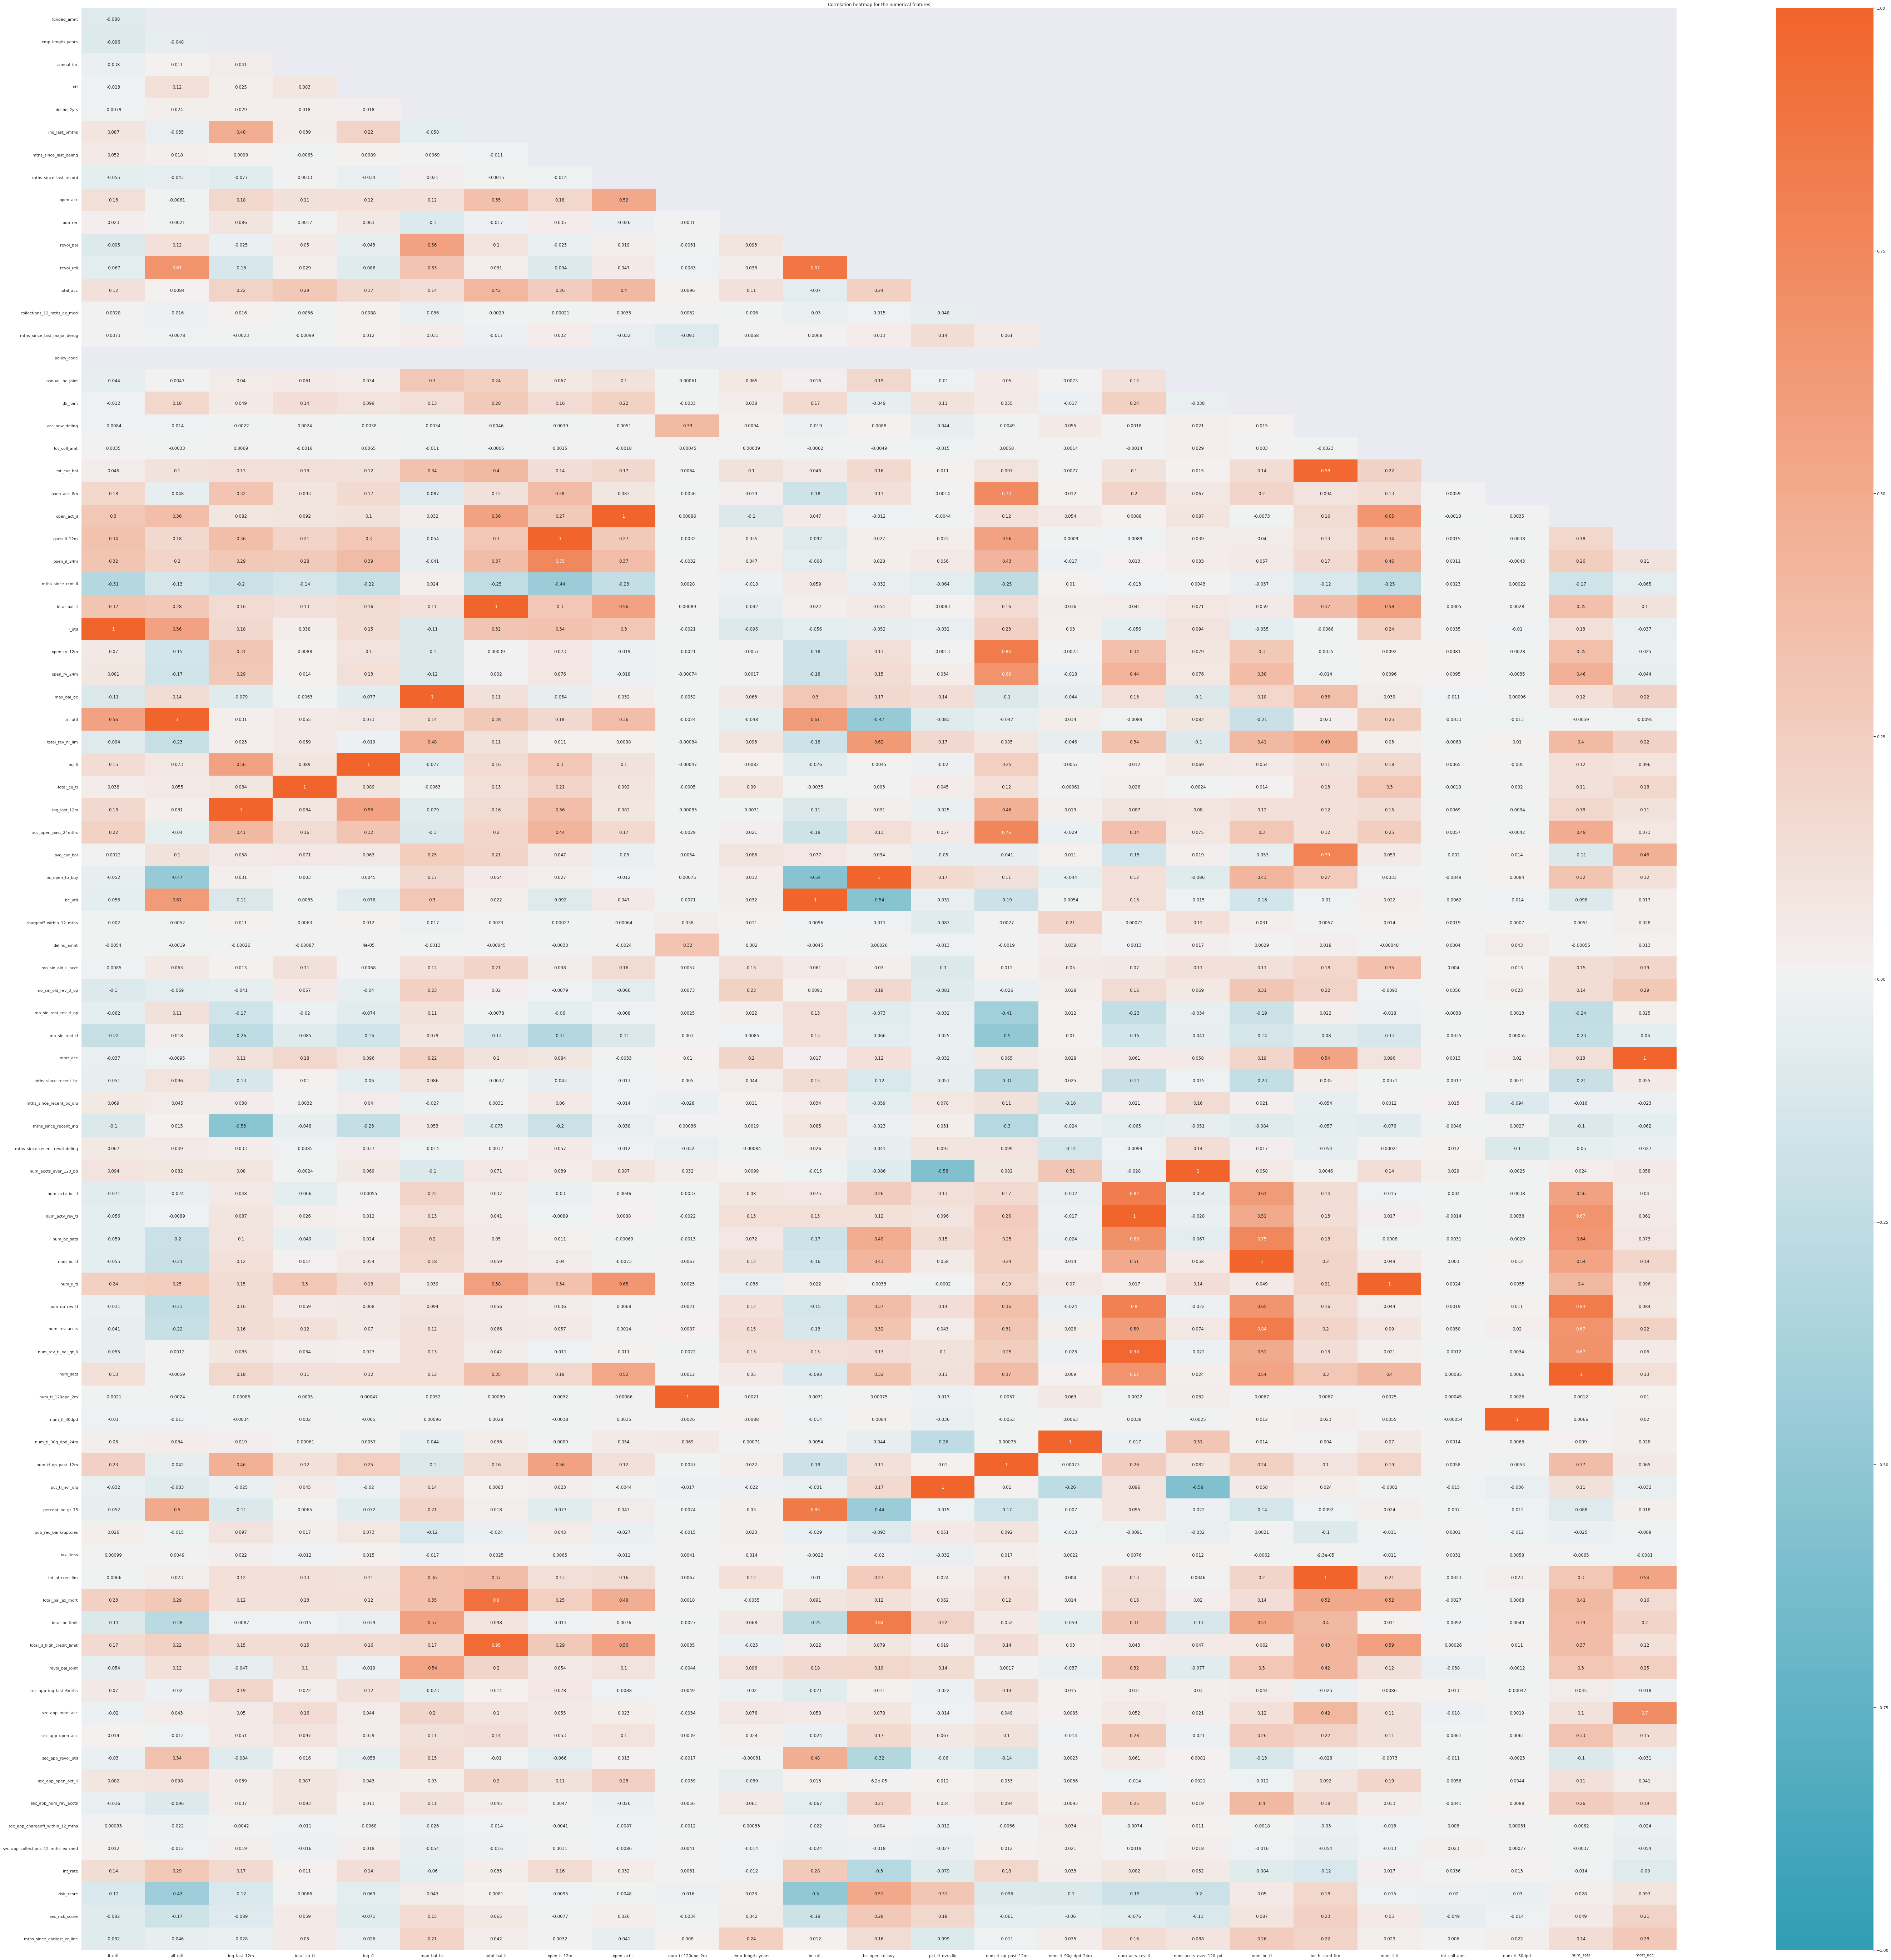

In [76]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))
mask = mask[1:, :-1]
corr = corr_df.iloc[1:, :-1].copy()

plt.figure(figsize=(100, 100))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

In [ ]:
def zip_state_to_coordinates(df):
    df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
    df["bin"] = df["zip_code"].str.strip("x") + df["state"]
    df = df.merge(bin_coord_means.reset_index(), on="bin", how="left")
    df = df.merge(state_coord_means.reset_index(), on="state", how="left")
    df["latitude"] = df["latitude"].fillna(df["state_latitude"])
    df["longitude"] = df["longitude"].fillna(df["state_longitude"])
    df.drop(["zip_code", "bin", "state"], axis=1, inplace=True)
    
    return df

In [ ]:
df.loc[:, missing_percentage[missing_percentage>30].index]

mths_since_last_delinq  mths_since_last_record  \
0                          30.0                     NaN   
1                           6.0                     NaN   
2                           NaN                     NaN   
3                           NaN                     NaN   
4                          12.0                     NaN   
...                         ...                     ...   
2260696                     9.0                     NaN   
2260697                    67.0                    72.0   
2260698                    37.0                     NaN   
2260699                     NaN                     NaN   
2260700                     NaN                     NaN   

         mths_since_last_major_derog  open_acc_6m  open_act_il  open_il_12m  \
0                               30.0          2.0          2.0          0.0   
1                                NaN          1.0          1.0          0.0   
2                                NaN          0.0          1.0          0.0   
3                                NaN          1.0          1.0          0.0   
4                                NaN          1.0          3.0          0.0   
...                              ...          ...          ...          ...   
2260696                         10.0          0.0          2.0          0.0   
2260697                         67.0          0.0          2.0          0.0   
2260698                         37.0          0.0          1.0          1.0   
2260699                          NaN          NaN          NaN          NaN   
2260700                          NaN          NaN          NaN          NaN   

         open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  \
0                1.0                21.0        4981.0     36.0          3.0   
1                1.0                19.0       18005.0     73.0          2.0   
2                4.0                19.0       10827.0     73.0          0.0   
3                1.0                23.0       12609.0     70.0          1.0   
4                3.0                14.0       73839.0     84.0          4.0   
...              ...                 ...           ...      ...          ...   
2260696          1.0                15.0       19765.0     46.0          0.0   
2260697          2.0                20.0       44785.0     78.0          1.0   
2260698          2.0                 7.0       32071.0     94.0          0.0   
2260699          NaN                 NaN           NaN      NaN          NaN   
2260700          NaN                 NaN           NaN      NaN          NaN   

         open_rv_24m  max_bal_bc  all_util  inq_fi  total_cu_tl  inq_last_12m  \
0                3.0       722.0      34.0     3.0          1.0           4.0   
1                3.0      6472.0      29.0     0.0          0.0           6.0   
2                2.0      2081.0      65.0     2.0          5.0           1.0   
3                1.0      6987.0      45.0     0.0          1.0           0.0   
4                7.0      9702.0      78.0     2.0          1.0           3.0   
...              ...         ...       ...     ...          ...           ...   
2260696          0.0      5141.0      51.0     3.0          0.0           2.0   
2260697          5.0      6172.0      73.0     0.0          0.0           1.0   
2260698          1.0      4093.0      84.0     3.0          1.0           2.0   
2260699          NaN         NaN       NaN     NaN          NaN           NaN   
2260700          NaN         NaN       NaN     NaN          NaN           NaN   

         mths_since_recent_bc_dlq  mths_since_recent_revol_delinq  
0                            69.0                            69.0  
1                             NaN                             6.0  
2                             NaN                             NaN  
3                             NaN                             NaN  
4                            12.0                            12.0  
...      

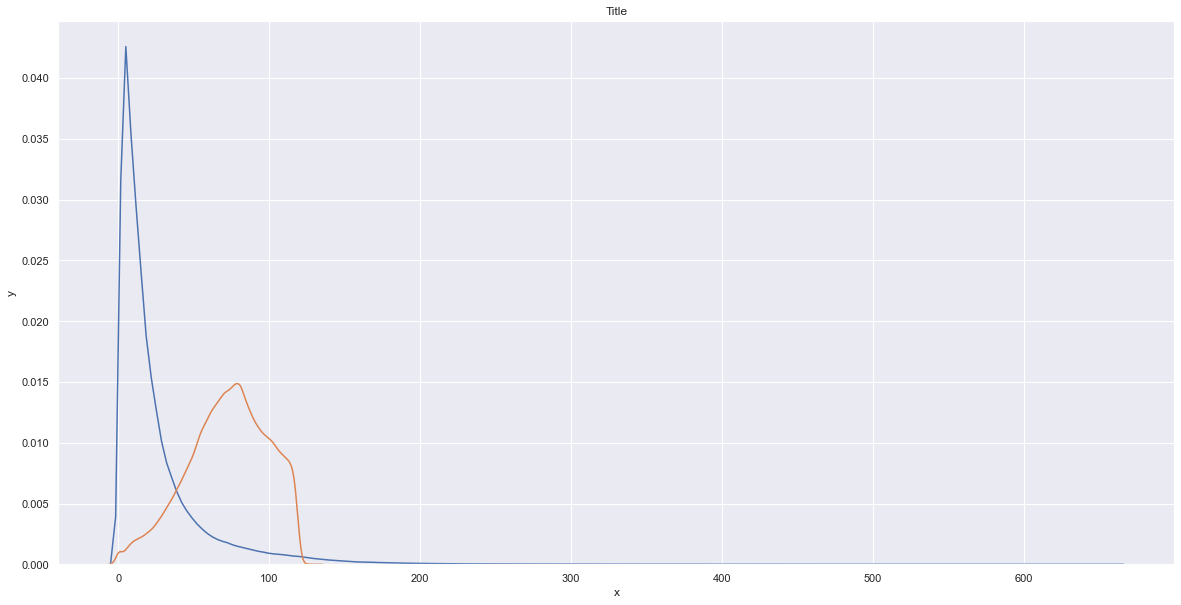

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df.loc[:,months_since_columns],
    x="mths_since_recent_bc",
)
ax = sns.kdeplot(
    data=df.loc[:,months_since_columns],
    x="mths_since_last_record",
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

In [ ]:
#TODO: fillna mnths_since transformer three types - double the na, bins + 1, binarize

In [ ]:
months_since_columns = (df.columns[(df.columns.str.contains("mths_since")) & (df.isna().sum()>40).values])

In [ ]:
months_since_columns

Index(['mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'mths_since_rcnt_il',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq'],
      dtype='object')

In [ ]:
df.columns.str.contains("mths_since")

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [ ]:
(df.isna().sum()>40).values

array([False, False,  True,  True, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False])

In [ ]:
df.loc[:,months_since_columns].isna().sum()*100/ df.shape[0]

mths_since_last_delinq            51.246715
mths_since_last_record            84.113069
mths_since_last_major_derog       74.309960
mths_since_rcnt_il                40.251099
mths_since_recent_bc               3.248771
mths_since_recent_bc_dlq          77.011511
mths_since_recent_inq             13.069751
mths_since_recent_revol_delinq    67.250910
dtype: float64